In [30]:
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from sklearn.cluster import DBSCAN
from scipy.optimize import curve_fit
from scipy.stats import mode

os.environ["CRDS_PATH"] = "/home/aqwork/miriroot/crds"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

# printing environment variables
print(os.environ['MIRISIM_ROOT'])
print(os.environ['PYSYN_CDBS'])
print(os.environ['CDP_DIR'])
print(os.environ['CRDS_PATH'])
print(os.environ['CRDS_SERVER_URL'])
print(os.environ['CRDS_CONTEXT'])

/home/aqwork/miriroot
/home/aqwork/miriroot/cdbs/
/home/aqwork/cdp
/home/aqwork/miriroot/crds
https://jwst-crds.stsci.edu
jwst_0641.pmap


In [31]:
# ip op paths and directories

mydir = os.getcwd()
mirisimopsource = '/20210912_233802_mirisim/det_images/'       # using output in /20210912_233802_mirisim , change mirisimopsource variable to switch folder
ipname = "det_image_seq1_MIRIMAGE_F1280Wexp1.fits"             # using "det_image_seq1_MIRIMAGE_F1280exp1.fits" input file, change ipname if other
mirisimopdir = mydir + mirisimopsource


# input file path

ippath = mirisimopdir + ipname
# print(ippath)

# output directory setup
my_output_dir = "pipeline_outputs/"
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

In [32]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)


    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.
    


In [33]:
# mask reference file exploration, also used by runpip function to set pixels associated with known detector artefacts as nan

# get pdq data
maskrefpath = '/home/aqwork/miriroot/crds/references/jwst/miri/jwst_miri_mask_0023.fits'
hdumask = fits.open(maskrefpath)
maskpdq = hdumask[1].data
hdumask.close()

# extract dnu pixels and plot
dnupix = np.where(np.bitwise_and(maskpdq,int(2**0)),1,0)
# fig,axs = plt.subplots(figsize = (10,10))
# axs.imshow(dnupix,origin='lower',cmap='Greys',interpolation='nearest')

# apply refmask
refmask = np.tile(dnupix,(1,40,1,1))
hdut = fits.open(ippath)
data = hdut[1].data
ndata = np.where(refmask == 1, np.nan, data)
hdut.close()

FileNotFoundError: [Errno 2] No such file or directory: '/home/aqwork/asteroids/velocity-determination-1d/20210912_233802_mirisim/det_images/det_image_seq1_MIRIMAGE_F1280Wexp1.fits'

In [ ]:
# import the updated versions of move source code and change pixeldq

import move_source_code as msc
import change_pixeldq as pixel

# import the step

from jwst.dq_init import dq_init_step

# print the description and options

print(dq_init_step.DQInitStep.__doc__)
print(dq_init_step.DQInitStep.spec)

# import the step
from jwst.jump import jump_step

# print the description and options
print(jump_step.JumpStep.__doc__)
print(jump_step.JumpStep.spec)

# import the step
from jwst.ramp_fitting import ramp_fit_step

# print the description and options
print(ramp_fit_step.RampFitStep.__doc__)
print(ramp_fit_step.RampFitStep.spec)

In [ ]:
# when using a different exposure, change ip

def runpip(use_existing_file,ip, mvx, pre = "pipeline_outputs"):
    
    # setup output directory, uses the supplied prefix and adds a suffix of motion rate to create new directory
    msc_output_prefix = pre

    moverate = mvx # sets the rate of motion
    
    msc_op_dir = msc_output_prefix+'x'+str(moverate)+'/'        # op directory for msc, the motion rate is added as a suffix
    msc_op_file = msc_op_dir+ipname[0:-5]+'_moved.fits'        # op file for msc
    
    
    # if path exists and using old file, then pull data
    # if msc_op_dir exists and asked to use existing file, try using the existing file, if file is missing continue
    #                                                      to simulate from the ip supplied and print error
    # if msc_op_dir exists and not asked to use existing file, print ignoring existing files and continue
    #                                                          to simulate from the ip supplied and print error 
    
    # if msc_op_dir does not exist and asked to use existing file, say doe not exist and simulate
    #                                                              from the ip supplied and print error
    
    # flag 'filled' tracks if we need to move the source or not
    
    if os.path.exists(msc_op_dir):
        if use_existing_file:
            try:
                print ('using existing file')
                dm_slopes =  datamodels.open(msc_op_dir+ipname[0:-5]+'_rate.fits')
                print('first output contains datamodel')

                print('second output contains path to\n')
                hdumoved = fits.open(msc_op_file)
                hdumoved.info()
                hdumoved.close()

                print('third output contains path to\n')
                opramp_path = msc_op_dir+ipname[0:-5]+'_ramp.fits'
                hduramp = fits.open(opramp_path)
                hduramp.info()
                hduramp.close()

                print('fourth output contains moverate: ',moverate)
                filled = 1
            except OSError as e:
                print(e)
                print('missing file(s), running custom pipeline')
                filled = 0
        else:
            print('ignoring existing files, running custom pipeline')
            filled = 0

            
    # if path does not exist then create new dir and if use existing is true then post message        
    if not os.path.exists(msc_op_dir):
        if use_existing_file:
            print('no existing file, running custom pipeline')
        os.mkdir(msc_op_dir)
        filled = 0
    
    if filled == 0:
        # generate refmask [1,40,1024,1032]
        refmask = np.tile(dnupix,(1,40,1,1))
        
        # run the msc code
        msc.move(ip, msc_op_file, refmask = refmask, velin = moverate)

        # use same input filename as above op file name
        dqi_op_file = msc_op_dir+ipname[0:-5]+'_moved_dqinitstep.fits'        # op file for msc

        # run the dqinit step
        dm_dqinit = dq_init_step.DQInitStep.call(msc_op_file, output_use_model=True, output_dir = msc_op_dir, save_results=True)

    #     print(dqi_op_file)

        cpdq_op_file = msc_op_dir+ipname        # op file for cpdq
        pixel.cpdq(dqi_op_file, cpdq_op_file)

    # remaining pipeline skipping dqinit and refpix (and ipc as done by Patrick Kavanagh in the tutorials)

        dm_slopes = Detector1Pipeline.call(cpdq_op_file, output_use_model=True, save_results=True, 
                                    output_dir=msc_op_dir, save_calibrated_ramp = True, steps={'dq_init': {'skip':True},'ipc': {'skip': True},
                                                                     'refpix': {'skip': True}, 'ramp_fit': {'save_opt': True}})

        opramp_path = msc_op_dir+ipname[0:-5]+'_ramp.fits' # ramp after the jump step extracted using the 'save_calibrated_ramp' argument
        
        
    
    return(dm_slopes,msc_op_file,opramp_path,moverate)

In [ ]:
# set a few constants

wasteroid = 0.010996
t_1 = 2.775
hdu = fits.open(ippath)
frames = hdu[1].shape[1]
hdu.close()
pixelscale = 0.11

In [ ]:
# base determined empirically from the data for masking obstructive structures
# similar mask for rows should be implemented in the case of 2d velocity simulations

def excol(mvrate, base = 416): 
    extracols = np.ceil(wasteroid * mvrate * t_1 * frames / pixelscale)
    nancols = int(base + extracols)
    return(nancols)

In [ ]:
# weighed addition function

def sumit(gdq, w=1):
    gdqs = gdq[0,0,:,:]
    for i,frame in enumerate(gdq[0,0:-1,:,:]):
        gdqs = gdqs + np.where(frame>0,gdq[0,i+1,:,:]*w,gdq[0,i+1,:,:])
    return(gdqs)

In [ ]:
# apply column mask and return science, dq and cumulative dq arrays

def maskandextract(ramps, gdq, mr, val = 2):
    cols = excol(mr)
    mramps = ramps[:,:,5:-5,cols:-10]
    mgdq = gdq[:,:,5:-5,cols:-10]
    mcrramps = np.bitwise_and(mgdq,int(2**val))
    mcrramps = np.bitwise_and(mgdq,int(2**val))
    hduds9 = fits.open(ippath)
    hduds9[1].data = mcrramps
    hduds9.writeto("fords9x"+str(mr)+".fits", overwrite=True)
    hduds9.close()
    mcrhitscum = np.sum(mcrramps,axis = 1)[0]
    xdata = np.sum(mcrhitscum,axis = 0)
    ydata = np.sum(mcrhitscum,axis = 1)
    return(mcrramps,mramps,mgdq,mcrhitscum,xdata,ydata)

In [ ]:
# used to plot all 3d diagrams, cluster argument decides which cluster to plot and '99' plots all clusters
# if no 'at' passed, aspect ratio is fixed to (1,1.5,0.5)
# az el determine viewing angle
# setat can be used to set aspect ratio when plotting specific clusters, based on their shapes

def plot3dgdq(data,cluster = 99,useaxes = (3,2,1), figdims =(10,10), fname = 'demo', az = -60, el = 30, at =  (0,0,0),
              xd = 0, setat = 0):
    # pass flag 99 to print multiple groups
    fig = plt.figure(figsize=figdims)
    ax = fig.add_subplot(1, 1, 1, projection='3d', azim = az, elev = el)
    if at == (0,0,0):
        at = (1,1.5,0.5)
    if cluster == 99:
        for clusters in np.unique(data):
            # if cluster is not nan, set
            if np.isnan(clusters) == 0:
                locs = np.where(data  == clusters)
                if clusters == -1:
                    plotlab = 'Noise'
                else:
                    plotlab = 'cluster '+str(int(clusters))
                ax.scatter(locs[useaxes[0]],locs[useaxes[1]],locs[useaxes[2]], label = plotlab,marker = 'o',alpha = 0.1)
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.set_box_aspect(at)
        print ('99 aspect used is :', at)
        ax.zaxis.set_rotate_label(False)
        if az == -90:
            
            ax.set_xlabel('\n \nColumns', fontsize=14)
#             ax.set_ylabel('Rows', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames', fontsize=14, rotation = 90)
            for line in ax.yaxis.get_ticklabels():
                line.set_visible(False)
            for line in ax.xaxis.get_ticklabels():
                line.set_visible(False)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
        elif az == 0:
            
#             ax.set_xlabel('Columns', fontsize=14)
            ax.set_ylabel('\n \nRows', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames', fontsize=14, rotation = 90)
            for line in ax.xaxis.get_ticklabels():
                line.set_visible(False)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
        else:
            ax.set_xlabel('\n \nColumns', fontsize=14)
            ax.set_ylabel('\n \nRows', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames', fontsize=14, rotation = 90)
#             for line in ax.yaxis.get_ticklines():
#                 line.set_visible(False)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
    else:
        locs = np.where(data == cluster)
#         print(locs)
        if setat:
            at = (max(locs[useaxes[0]]), max(locs[useaxes[1]]), 0.5*(max(max(locs[useaxes[0]]), max(locs[useaxes[1]]))))
        print ('aspect used is :', at)
        ax.set_box_aspect(at)
        ax.scatter(locs[useaxes[0]],locs[useaxes[1]],locs[useaxes[2]], label = 'cluster_'+str(cluster), c = 'red', marker = 'o',alpha = 0.1)
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.zaxis.set_rotate_label(False)
        if az == -90:
            ax.set_xlabel('\n \nColumns', fontsize=14)
#             ax.set_ylabel('\n \nRows', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames', fontsize=14, rotation = 90)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            for line in ax.yaxis.get_ticklabels():
                        line.set_visible(False)
            fig.tight_layout()
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
        elif az == 0:
#             ax.set_xlabel('\n \nColumns', fontsize=14)
            ax.set_ylabel('\n \nRows', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames', fontsize=14, rotation = 90)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
            for line in ax.xaxis.get_ticklabels():
                line.set_visible(False)
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
        else:
            ax.set_xlabel('\n \nColumns', fontsize=14)
            ax.set_ylabel('\n \nRows', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames', fontsize=14, rotation = 90)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
#             for line in ax.xaxis.get_ticklines():
#                 line.set_visible(False)
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
            
    plt.legend()
    return(fig,ax)

In [ ]:
# along the frames axis, samples were scaled by eps/2 to make sure only the two adjacent frames fall within the neighbourhood
# crramp input has to be a signature in a background of zeroes
def buildsamples(crramp, eps = 5, plot = 0, checkforval = 0):
    print('unique values in the data passed to buildsamples are', np.unique(crramp))
#     crramp = crramp[crramp != np.nan]
    if plot == 1:
        plot3dgdq(crramp)
    mcrhitramps_shrink = np.where(crramp!=0)
    sampst = np.vstack((mcrhitramps_shrink[0],mcrhitramps_shrink[1],mcrhitramps_shrink[2],mcrhitramps_shrink[3]))
    sampsst = np.vstack((mcrhitramps_shrink[0],mcrhitramps_shrink[1]*(eps/2),mcrhitramps_shrink[2],mcrhitramps_shrink[3]))
    sampss = sampsst.T
    samps = sampst.T
    print('shape of samps array: ',samps.shape)
    print('shape of sampss array: ',sampss.shape)
    return(samps,sampss)

In [ ]:
# use the samples and groupdq ramps to produce 2 groupdq arrays labelled with cluster numbers,
# prefix spec_ indicates a specific cluster passed by grpno and comp_ is a compiled set of all clusters

def lsets(crramps, unscaled_samples, scaled_samples, labels, grpno = 0): #(explain)
    complabelledset = np.copy(crramps).astype('float64')
    complabelledset = np.where(complabelledset == 0, np.nan, complabelledset)
    speclabelledset = np.copy(crramps).astype('float64')
    
    # add all labels to complabelledset
    for num,val in enumerate(unscaled_samples):
#         print(val)
        complabelledset[val[0],val[1],val[2],val[3]] = labels[num]
    
    # keep only the specific label passed
    speclabels = np.where(labels == grpno,1,np.nan)
    for num,val in enumerate(unscaled_samples):
#         print(val)
        speclabelledset[val[0],val[1],val[2],val[3]] = speclabels[num]
    return(complabelledset,speclabelledset)

In [ ]:
# span = 1 checks clusters for producing jumps across a range of frames. if minframe >= lower limit (usually 4)
# or maxframe <= upperlimit (34), span chack is passed

# eps and core are the most important parameters that define the cluster neighbourhood and minimum sample within neighbourhood
# that defines a core point (clusters cannot exist without core points)

def cluster(crramps, unscaled_samples, scaled_samples, eps = 5, core = 180, grpno = 0,span = 0, vel = 0):
    db = DBSCAN(eps=eps, min_samples = core).fit(scaled_samples)
    
    labels = db.labels_
    clusters = np.unique(labels)
    clusters = clusters[clusters != -1]
    print(clusters)
    no_clusters = len(np.unique(labels))
    no_noise = np.sum(np.array(labels) == -1, axis=0)
    print('Estimated no. of clusters: %d' % no_clusters,' with labels :', np.unique(labels))
    print('Estimated no. of noise points: %d' % no_noise)
    print('number of samples categorised: ',labels.shape)
    if span == 1:
        if vel == 30:
            ll = 9
        else:
            ll = 4
        for cname in clusters:
            locs = unscaled_samples[np.where(labels == cname)]
            print('range of frames for cluster',cname,':',min(locs[:,1]), max(locs[:,1]))
            if min(locs[:,1]) >= ll:
                print('cluster being dropped due to min frame criteria:', cname)
                labels = np.where(labels == cname, -1, labels)
            elif max(locs[:,1]) <= 34:
                print('cluster being dropped due to max frame criteria:', cname)
                labels = np.where(labels == cname, -1, labels)
            else:
                print('asteroid detected in cluster', cname)
    astclusters = np.unique(labels)
    if (len(astclusters) == 1) and (astclusters[0] == -1):
        print('only one cluster (-1), therefore no asteroid found')
        return(0,0,0)
    else:
        print('clusters representing asteroids :', astclusters[astclusters != -1])
        lcls = []
        lsls = []
        for grp in astclusters:
            complabelledset,speclabelledset = lsets(crramps, unscaled_samples, scaled_samples, labels, grpno = grp)
            lcls.append(complabelledset)
            lsls.append(speclabelledset)
    print('astcluster returned is :', astclusters)
    return(lcls,lsls,astclusters)

In [ ]:
# fitting a line to the cluster, one component of velocity only
def curve(x,m,c):
    return((m*x)+c)

# fit to all points
def fit2dline(func,f,x, iclust, loop = 'na:'):

    popt, pcov = curve_fit(curve, f,x)

    print(loop+' for cluster'+str(iclust)+' optimal slope multiplied by pixel scale and divided by frame time :', round(popt[0]*0.11/2.775,10))
    
    return (popt,pcov)

# calculate frame centroid first and then fit, mean argument decides the measure of central tendency used to define centroid
def fit2dlinecent(func,f,x, iclust, loop = 'na:', mean = 1):
    lx = []
    lf = []
    for fs in np.unique(f):
        xs = x[f==fs]
        if mean:
            xcentarr=np.mean(xs)
            lx.append(xcentarr)
        else:
            xcentarr=mode(xs)[0]
            lx.append(xcentarr[0])
        lf.append(fs)
        
#     for i,x in enumerate(lx):
#         if x == 272:
#             lx[i] = 268
            
#     print(lx,lf)
    
    popt, pcov = curve_fit(curve, lf,lx)

    print(loop+' for cluster'+str(iclust)+' optimal slope multiplied by pixel scale and divided by frame time :', round(popt[0]*0.11/2.775,10))
    
    return (popt,pcov,lx,lf)

In [ ]:
def speedclustercombo(vel = 5, clusternum = 99, ep = 5, core = 160, span = 0, fn = 'demo', pafname = 'demo',
                      az = -60, el = 30, printall = 0, flux = 0,colim = 99, cent = 1, mean = 1, setat = 0):
    if cent:    
        # move stat simulation
        (dm,moved,jumpdet,mvrate) = runpip(1,ippath, vel) # return(dm_slopes,msc_op_file,opramp_path,moverate
    #     print(mvrate)
        hduramp = fits.open(jumpdet)
        ramp = hduramp[1].data
        gdq = hduramp[3].data
        hduramp.close()

        # mask data and extract
        mcrhitramps,mramp,mgdq,mcrhitscum,xdata,ydata  = maskandextract(ramp, gdq, mr = mvrate)
    #     hduramp = fits.open(mramp)
    #     mramp = hduramp[1].data
    #     hduramp.close()

        if printall == 1:
            plot3dgdq(mgdq,cluster = 4, fname = pafname+'0', az = az, el = el)
            fig,ax = plt.subplots(1,1, figsize = (10,10))
            ax.imshow(mramp[0,-1,:,:], origin = 'lower', cmap = 'gist_gray', norm = LogNorm(vmin = 1e4, vmax = 6e4))


        ''' cluster the jumps, find asteroids and plot detections '''

        samps,sampss = buildsamples(mcrhitramps)
    #     print(cluster)
        cls, sls, clusters = cluster(mcrhitramps, samps, sampss, eps = ep , core = core, span = span, vel = vel)
        if (cls, sls, clusters) == (0,0,0):
            print('premature exit')
        else:
            plot3dgdq(cls[-1],cluster = clusternum, fname = fn+'1', az = az, el = el)
            clusters = clusters[clusters != -1]

            ''' for each cluster with an asteroid, plot cluster, extract fluxes and plot fluxes '''        

            for icluster in clusters:
                print('checking cluster : ', icluster)
                scatpoints = np.where(cls[-1] == icluster)
                f = scatpoints[1]
                x = scatpoints[3]
    #             print(f.shape)
    #             print(x.shape)
                popt,pcov,xlist,flist = fit2dlinecent(curve,f,x, iclust = icluster, loop = 'in the first fit')

                (fig,ax) = plot3dgdq(cls[-1], cluster = icluster, fname = fn+'2', az = az, el = el, at = (0,0,0), setat = setat)

                zs = np.linspace(0,39,40)
                xs = curve(zs,popt[0],popt[1])
                yrange = np.where(cls[-1] == icluster)
                ploty = mode(yrange[2])[0]
                print('ploty is ',ploty)
                ys = np.full_like(xs,ploty)

    #             print(zs.shape,xs.shape,ys.shape)
                ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
                ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                plt.legend()
                plt.show()
                fig.savefig(fn+'2'+".png",format='png')
                fig.savefig(fn+'2'+".pdf",format='pdf')

                if flux:
                    ymax = max(scatpoints[2])
                    ymin = min(scatpoints[2])
                    xmax = max(scatpoints[3])
                    xmin = min(scatpoints[3])

                    yup = ymax + 10
                    ydown = max(0,ymin - 10)
                    xup = xmax + 10
                    xdown = max(0,xmin - 10)

                    print(yup,ydown,xup,xdown)

                    asteroid = mramp[:,:,ydown:yup,xdown:xup]
        #             print(asteroid.shape)
                    difim = np.diff(asteroid, axis = 1)[:,1:,:,:]
    #                 print(difim.shape)
                    fig,ax = plt.subplots(1,2,figsize = (10,10))
                    img = np.mean(difim[0,:,:,:],axis = 0)
                    ax[0].imshow(img,origin = 'lower')
                    co = np.percentile(difim.flatten(),colim)
                    print('flux cutoff used for defining asteroid core = ',co)
                    h1 = plt.hist(difim.flatten(), bins = 100, histtype = 'step', log = True)
                    ax[1].set_title("flux distrubution")
                    ax[1].set_ylabel("count of pixels")
                    ax[1].set_xlabel("counts / DN")
                    plt.show()

                    if icluster == 0:
                        icluster = 999
                        print('changed cluster number to 999 for ease of application')
                    a = np.where(difim >= co,icluster,0)
                    f = np.where(a == icluster)[1]
                    x = np.where(a == icluster)[3]

    #                 print(f.shape)
    #                 print(x.shape)

                    popt,pcov,xlist,flist = fit2dlinecent(curve,f,x, iclust = icluster, loop = 'in the flux field', mean = mean)
                    (fig,ax) = plot3dgdq(a, useaxes = (3,2,1), cluster = icluster, fname = fn+'3',
                                         az = az, el = el, at = (0,0,0), setat = setat)

                    for line in ax.yaxis.get_ticklabels():
                        line.set_visible(False)
                    axlabs = []
    #                 print(ax.xaxis.get_ticklabels())
                    for line in ax.xaxis.get_ticklabels():
                        txt =  line.get_text()
#                         print(ord(txt[0]),xdown)
    #                     print('converting and adding: ',txt)
                        txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
                        axlabs.append(txt)
                    ax.set_xticklabels(axlabs)

    #                 line.set_visible(False)

                    zs = np.linspace(-4,43,48)
                    xs = curve(zs,popt[0],popt[1])
                    yrange = np.where(a == icluster)
                    ploty = mode(yrange[2])[0]
                    ys = np.full_like(xs,ploty)

    #                 print(zs.shape,xs.shape,ys.shape)
                    ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
                    ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                    plt.legend()
                    plt.show()
                    fig.savefig(fn+'3'+".png",format='png')
                    fig.savefig(fn+'3'+".pdf",format='pdf')



                    ''' cluster the fluxes and plot, if more than one cluster detected again, renege '''        


                    sampsrs,sampssrs = buildsamples(a)
                    print('checking cluster : ', cluster)
                    clsrs, slsrs, clustersrs = cluster(a, sampsrs, sampssrs, eps = 3, core = 20, span = 1, vel = vel)
                    if (clsrs, slsrs, clustersrs) == (0,0,0):
                        print('premature exit in the cluster loop for cluster ',icluster)
                    else:
                        clustersrs = clustersrs [clustersrs != -1]
                        if len(clustersrs) > 1:
                            print('still more than one cluster, abandoning')
            #             print(len(cls))
                        else:
                            if clustersrs[0] == 0:
                                clustersrs[0] = 999
                                clsrs[-1] = np.where(clsrs[-1] == 0,999,clsrs[-1])
                                print('changed cluster number to 1 for ease of application')
                            scatpoints = np.where(clsrs[-1] == clustersrs[0],clustersrs[0],0)
                            f = np.where(scatpoints == clustersrs[0])[1]
                            x = np.where(scatpoints == clustersrs[0])[3]
    #                         print(f.shape)
    #                         print(x.shape)

                            popt,pcov,xlist,flist = fit2dlinecent(curve,f,x, iclust = clustersrs[0],
                                                                  loop = 'in the flux field after another dbscan', mean = mean)
    #                         popt,pcov = fit2dline(curve,f,x, iclust = clustersrs[0], loop = 'in the flux field after another dbscan')
    #                         plot3dgdq(cls[-1], cluster = clusters[0], fname = fn, az = az, el = el)

                            (fig,ax) = plot3dgdq(clsrs[-1], useaxes = (3,2,1), cluster = clustersrs[0],
                                                 fname = fn+'4', az = az, el = el, at = (0,0,0), setat = setat)

                            for line in ax.yaxis.get_ticklabels():
                                line.set_visible(False)
    #                             print(ax.xaxis.get_ticklabels())
                            axlabs = []
                            for line in ax.xaxis.get_ticklabels():
                                txt =  line.get_text()
    #                             print('converting and adding: ',txt)
                                txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
    #                             txt = str(xdown+int(txt))
                                axlabs.append(txt)
                            ax.set_xticklabels(axlabs)

                            zs = np.linspace(0,39,40)
                            xs = curve(zs,popt[0],popt[1])
                            yrange = np.where(clsrs[-1] == clustersrs[0])
                            ploty = mode(yrange[2])[0]
                            ys = np.full_like(xs,ploty)

            #                 print(zs.shape,xs.shape,ys.shape)
                            ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
                            ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                            plt.legend()
                            plt.show()
                            fig.savefig(fn+'4'+".png",format='png')
                            fig.savefig(fn+'4'+".pdf",format='pdf')
                            
                            
                            
                            
                            
    else:
        # MOVING
        (dm,moved,jumpdet,mvrate) = runpip(1,ippath, vel) # return(dm_slopes,msc_op_file,opramp_path,moverate
    #     print(mvrate)
        hduramp = fits.open(jumpdet)
        ramp = hduramp[1].data
        gdq = hduramp[3].data
        hduramp.close()

        # mask data and extract cr hits
        mcrhitramps,mramp,mgdq,mcrhitscum,xdata,ydata  = maskandextract(ramp, gdq, mr = mvrate)
    #     hduramp = fits.open(mramp)
    #     mramp = hduramp[1].data
    #     hduramp.close()

        if printall == 1:
            plot3dgdq(mgdq,cluster = 4, fname = pafname+'0', az = az, el = el)
            fig,ax = plt.subplots(1,1, figsize = (10,10))
            ax.imshow(mramp[0,-1,:,:], origin = 'lower', cmap = 'gist_gray', norm = LogNorm(vmin = 1e4, vmax = 6e4))


        ''' cluster the jumps find asteroids and plot detections '''

        samps,sampss = buildsamples(mcrhitramps)
    #     print(cluster)
        cls, sls, clusters = cluster(mcrhitramps, samps, sampss, eps = ep , core = core, span = span, vel = vel)
        if (cls, sls, clusters) == (0,0,0):
            print('premature exit')
        else:
            plot3dgdq(cls[-1],cluster = clusternum, fname = fn+'1', az = az, el = el, at = (0,0,0))
            clusters = clusters[clusters != -1]

            ''' for each cluster with an asteroid, plot cluster, extract fluxes and plot fluxes '''        

            for icluster in clusters:
                print('checking cluster : ', icluster)
                scatpoints = np.where(cls[-1] == icluster)
                f = scatpoints[1]
                x = scatpoints[3]
    #             print(f.shape)
    #             print(x.shape)
                popt,pcov = fit2dline(curve,f,x, iclust = icluster, loop = 'in the first fit')

                (fig,ax) = plot3dgdq(cls[-1], cluster = icluster, fname = fn+'2', az = az, el = el, at = (0,0,0), setat = setat)

                zs = np.linspace(0,39,40)
                xs = curve(zs,popt[0],popt[1])
                yrange = np.where(cls[-1] == icluster)
                ploty = mode(yrange[2])[0]
                print('ploty is ',ploty)
                ys = np.full_like(xs,ploty)

    #             print(zs.shape,xs.shape,ys.shape)
                ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
#                 ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                plt.legend()
                plt.show()
                fig.savefig(fn+'2'+".png",format='png')
                fig.savefig(fn+'2'+".pdf",format='pdf')

                if flux:
                    ymax = max(scatpoints[2])
                    ymin = min(scatpoints[2])
                    xmax = max(scatpoints[3])
                    xmin = min(scatpoints[3])

                    yup = ymax + 10
                    ydown = max(0,ymin - 10)
                    xup = xmax + 10
                    xdown = max(0,xmin - 10)

                    print(yup,ydown,xup,xdown)

                    asteroid = mramp[:,:,ydown:yup,xdown:xup]
        #             print(asteroid.shape)
                    difim = np.diff(asteroid, axis = 1)[:,1:,:,:]
                    print(difim.shape)
                    fig,ax = plt.subplots(1,2,figsize = (10,10))
                    img = np.mean(difim[0,1:,:,:],axis = 0)
                    ax[0].imshow(img,origin = 'lower')
                    co = np.percentile(difim.flatten(),colim)
                    print('flux cutoff used for defining asteroid core = ',co)
                    h1 = plt.hist(difim.flatten(), bins = 100, histtype = 'step', log = True)
                    ax[1].set_title("flux distrubution")
                    ax[1].set_ylabel("count of pixels")
                    ax[1].set_xlabel("counts / DN")
                    plt.show()

#                     corepoints = np.where(difim >= co)
#                     a = np.zeros_like(difim)
        #             print(corepoints.shape)
#                     a[corepoints] = icluster
                    if icluster == 0:
                        icluster = 999
                        print('changed cluster number to 999 for ease of application')
                    a = np.where(difim >= co,icluster,0)
                    f = np.where(a == icluster)[1]
                    x = np.where(a == icluster)[3]
    #                 print(f.shape)
    #                 print(x.shape)
                    popt,pcov = fit2dline(curve,f,x, iclust = icluster, loop = 'in the flux field')
                    (fig,ax) = plot3dgdq(a, useaxes = (3,2,1), cluster = icluster, fname = fn+'3',
                                         az = az, el = el, at = (0,0,0), setat = setat)

                    for line in ax.yaxis.get_ticklabels():
                        line.set_visible(False)
                    axlabs = []
    #                 print(ax.xaxis.get_ticklabels())
                    for line in ax.xaxis.get_ticklabels():
                        txt =  line.get_text()
#                         print(ord(txt[0]),xdown)
    #                     print('converting and adding: ',txt)
                        txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
                        axlabs.append(txt)
                    ax.set_xticklabels(axlabs)

    #                 line.set_visible(False)

                    zs = np.linspace(-4,43,48)
                    xs = curve(zs,popt[0],popt[1])
                    yrange = np.where(a == icluster)
                    ploty = mode(yrange[2])[0]
                    ys = np.full_like(xs,ploty)

    #                 print(zs.shape,xs.shape,ys.shape)
                    ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
#                     ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                    plt.legend()
                    plt.show()
                    fig.savefig(fn+'3'+".png",format='png')
                    fig.savefig(fn+'3'+".pdf",format='pdf')



                    ''' cluster the fluxes and plot, if more than one cluster detected again, renege '''        

                    
                    sampsrs,sampssrs = buildsamples(a)
                    print('checking cluster : ', icluster)
                    clsrs, slsrs, clustersrs = cluster(a, sampsrs, sampssrs, eps = 3, core = 20, span = 1, vel = vel)
                    if (clsrs, slsrs, clustersrs) == (0,0,0):
                        print('premature exit in the cluster loop for cluster ',icluster)
                    else:
                        clustersrs = clustersrs [clustersrs != -1]
                        if len(clustersrs) > 1:
                            print('still more than one cluster, abandoning')
            #             print(len(cls))
                        else:
                            if clustersrs[0] == 0:
                                clustersrs[0] = 999
                                clsrs[-1] = np.where(clsrs[-1] == 0,999,clsrs[-1])
                                print('changed cluster number to 1 for ease of application')
                            scatpoints = np.where(clsrs[-1] == clustersrs[0],clustersrs[0],0)
                            f = np.where(scatpoints == clustersrs[0])[1]
                            x = np.where(scatpoints == clustersrs[0])[3]
#                             print(f.shape)
#                             print(x.shape)
#                             print(np.unique(clsrs[-1]))

                            popt,pcov = fit2dline(curve,f,x, iclust = clustersrs[0],
                                                                  loop = 'in the flux field after another dbscan')
    #                         popt,pcov = fit2dline(curve,f,x, iclust = clustersrs[0], loop = 'in the flux field after another dbscan')
    #                         plot3dgdq(cls[-1], cluster = clusters[0], fname = fn, az = az, el = el)

                            (fig,ax) = plot3dgdq(scatpoints, useaxes = (3,2,1), cluster = clustersrs[0],
                                                 fname = fn+'4', az = az, el = el, at = (0,0,0), setat = setat)

                            for line in ax.yaxis.get_ticklabels():
                                line.set_visible(False)
    #                             print(ax.xaxis.get_ticklabels())
                            axlabs = []
                            for line in ax.xaxis.get_ticklabels():
                                txt =  line.get_text()
    #                             print('converting and adding: ',txt)
                                txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
    #                             txt = str(xdown+int(txt))
                                axlabs.append(txt)
                            ax.set_xticklabels(axlabs)

                            zs = np.linspace(0,39,40)
                            xs = curve(zs,popt[0],popt[1])
                            yrange = np.where(clsrs[-1] == clustersrs[0])
                            ploty = mode(yrange[2])[0]
                            ys = np.full_like(xs,ploty)

            #                 print(zs.shape,xs.shape,ys.shape)
                            ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
#                             ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                            plt.legend()
                            plt.show()
                            fig.savefig(fn+'4'+".png",format='png')
                            fig.savefig(fn+'4'+".pdf",format='pdf')
    return(mramp)

# run all cells upto this point before proceeding below

### basic fit : if you run a cell for a new velocity, it will produce a new output file from runpip and might take a little time to run

using existing file
[Errno 2] No such file or directory: 'pipeline_outputsx0.05/det_image_seq1_MIRIMAGE_F1280Wexp1_rate.fits'
missing file(s), running custom pipeline


2021-09-14 12:27:52,324 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2021-09-14 12:27:52,327 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2021-09-14 12:27:52,433 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('pipeline_outputsx0.05/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits',).
2021-09-14 12:27:52,434 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputsx0.05/', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-09-14 12:27:52,754 - stpipe.DQInitStep - INFO - Using MASK reference file /home/aqwork/miriroot/crds/references/jwst/miri/jwst_miri_mask_0023.fits
2021-09-14 12:27:53,354 - stpipe.DQInitStep - INFO - Saved model in pipeline_outputsx0.05/det_image_seq1_MI

2021-09-14 12:27:54,351 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_F1280Wexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-09-14 12:27:54,356 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/aqwork/miriroot/crds/references/jwst/miri/jwst_miri_dark_0058.fits'.
2021-09-14 12:27:54,357 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/aqwork/miriroot/crds/references/jwst/miri/jwst_miri_gain_0008.fits'.
2021-09-14 12:27:54,359 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/aqwork/miriroot/crds/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2021-09-14 12:27:54,360 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-09-14 12:27:54,361 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE referenc

2021-09-14 12:28:04,309 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-09-14 12:28:04,369 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 40, 1024, 1032) from det_image_seq1_MIRIMAGE_F1280Wexp1.fits>,).
2021-09-14 12:28:04,371 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'pipeline_outputsx0.05', 'type': 'baseline'}
2021-09-14 12:28:04,388 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/aqwork/miriroot/crds/references/jwst/miri/jwst_miri_rscd_0010.fits
2021-09-14 12:28:04,558 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2021-09-14 12:28:04,618 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args 

2021-09-14 12:32:25,285 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-09-14 12:32:25,368 - stpipe.Detector1Pipeline - INFO - Saved model in pipeline_outputsx0.05/det_image_seq1_MIRIMAGE_F1280Wexp1_rateints.fits
2021-09-14 12:32:25,369 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-09-14 12:32:25,423 - stpipe.Detector1Pipeline - INFO - Saved model in pipeline_outputsx0.05/det_image_seq1_MIRIMAGE_F1280Wexp1_rate.fits
2021-09-14 12:32:25,423 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


unique values in the data passed to buildsamples are [0 4]
shape of samps array:  (13030, 4)
shape of sampss array:  (13030, 4)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Estimated no. of clusters: 21  with labels : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Estimated no. of noise points: 11111
number of samples categorised:  (13030,)
range of frames for cluster 0 : 2 5
cluster being dropped due to max frame criteria: 0
range of frames for cluster 1 : 2 38
asteroid detected in cluster 1
range of frames for cluster 2 : 2 5
cluster being dropped due to max frame criteria: 2
range of frames for cluster 3 : 3 8
cluster being dropped due to max frame criteria: 3
range of frames for cluster 4 : 2 6
cluster being dropped due to max frame criteria: 4
range of frames for cluster 5 : 9 16
cluster being dropped due to min frame criteria: 5
range of frames for cluster 6 : 15 20
cluster being dropped due to min frame criteria: 6
range of frames for cluster 7

2021-09-14 12:32:26,968 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:23: PendingDeprecationWarning: 
The w_xaxis attribute will be deprecated in a future version. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

2021-09-14 12:32:26,969 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:24: PendingDeprecationWarning: 
The w_yaxis attribute will be deprecated in a future version. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

2021-09-14 12:32:26,970 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:25: PendingDeprecationWarning: 
The w_zaxis attribute will be deprecated in a future version. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))



99 aspect used is : (1, 1.5, 0.5)


2021-09-14 12:32:28,146 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:74: PendingDeprecationWarning: 
The w_xaxis attribute will be deprecated in a future version. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

2021-09-14 12:32:28,147 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:75: PendingDeprecationWarning: 
The w_yaxis attribute will be deprecated in a future version. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

2021-09-14 12:32:28,147 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:76: PendingDeprecationWarning: 
The w_zaxis attribute will be deprecated in a future version. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))



checking cluster :  1
in the first fit for cluster1 optimal slope multiplied by pixel scale and divided by frame time : 0.0104144702
aspect used is : (1, 1.5, 0.5)
ploty is  [524]


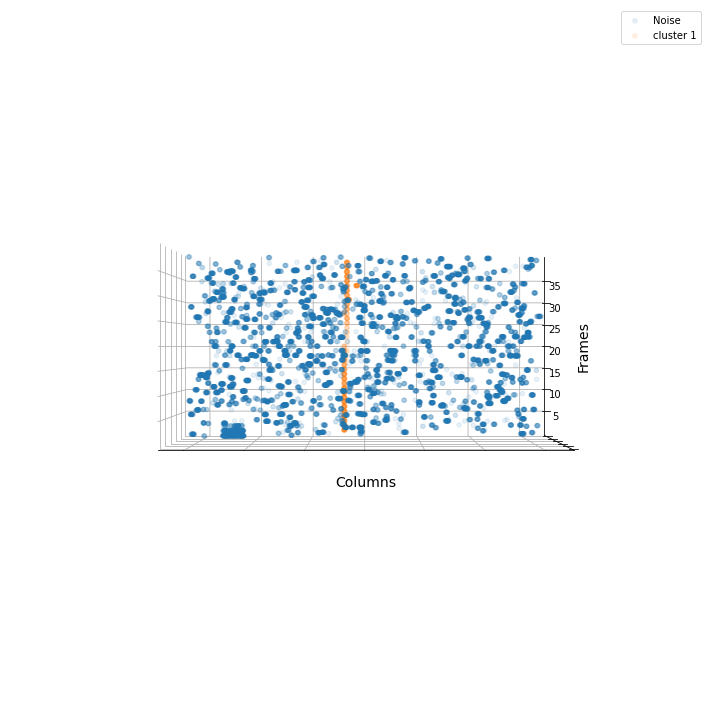

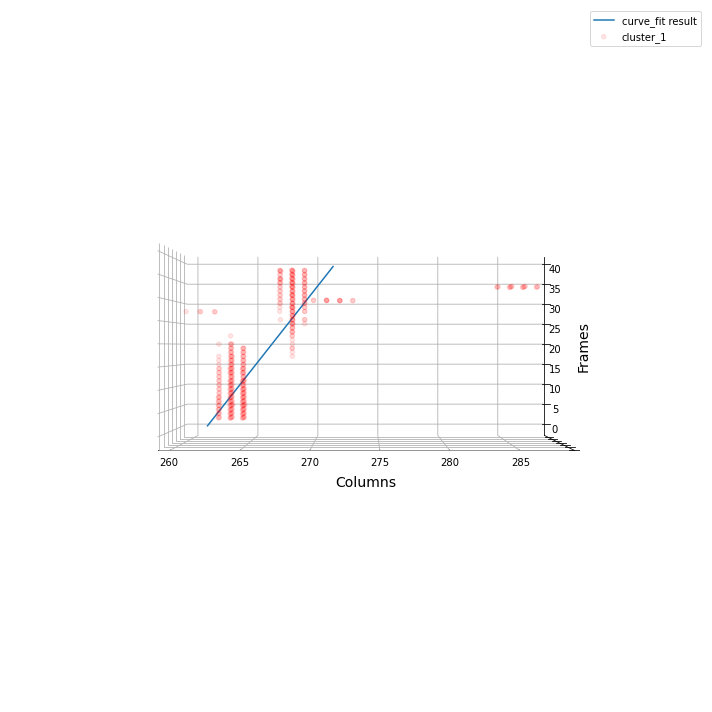

537 486 297 251
(1, 38, 51, 46)
flux cutoff used for defining asteroid core =  368.69289062499956


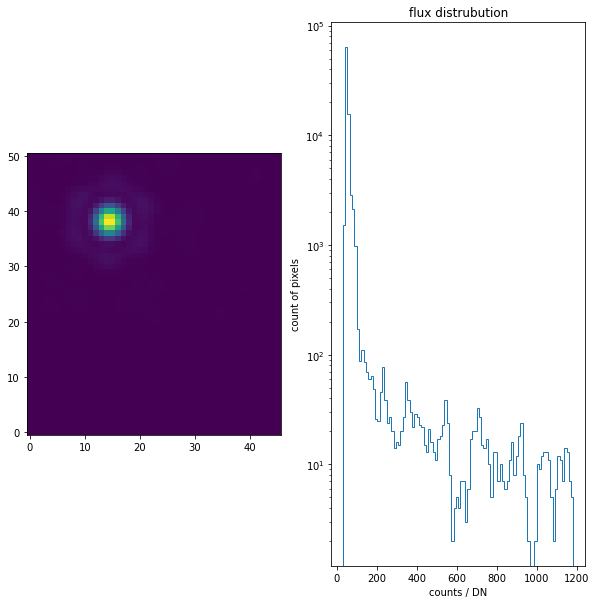

2021-09-14 12:32:29,210 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:74: PendingDeprecationWarning: 
The w_xaxis attribute will be deprecated in a future version. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

2021-09-14 12:32:29,210 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:75: PendingDeprecationWarning: 
The w_yaxis attribute will be deprecated in a future version. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

2021-09-14 12:32:29,211 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:76: PendingDeprecationWarning: 
The w_zaxis attribute will be deprecated in a future version. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

2021-09-14 12:32:29,397 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:311: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



in the flux field for cluster1 optimal slope multiplied by pixel scale and divided by frame time : 0.0009044266
aspect used is : (1, 1.5, 0.5)


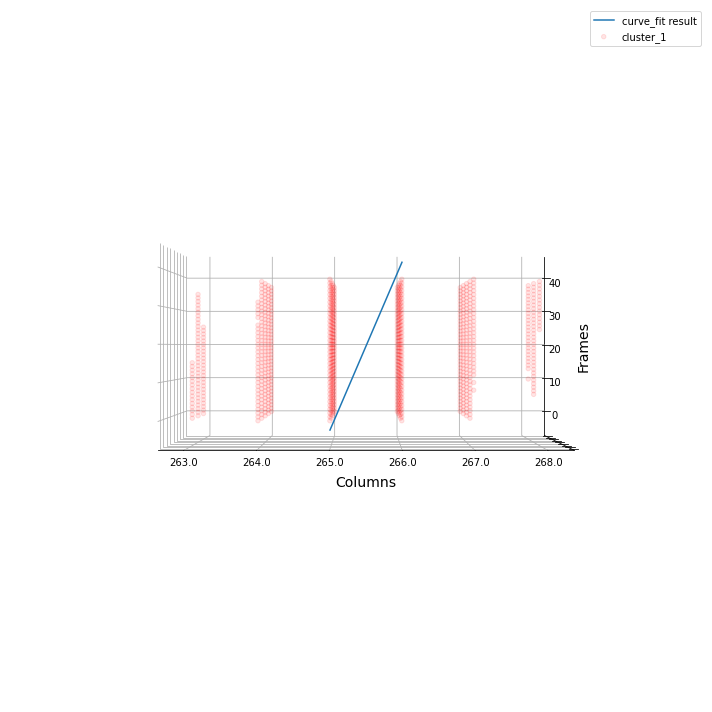

2021-09-14 12:32:29,677 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:74: PendingDeprecationWarning: 
The w_xaxis attribute will be deprecated in a future version. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

2021-09-14 12:32:29,678 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:75: PendingDeprecationWarning: 
The w_yaxis attribute will be deprecated in a future version. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

2021-09-14 12:32:29,679 - stpipe - WARNING - <ipython-input-11-4cd81bceb73a>:76: PendingDeprecationWarning: 
The w_zaxis attribute will be deprecated in a future version. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))



unique values in the data passed to buildsamples are [0 1]
shape of samps array:  (892, 4)
shape of sampss array:  (892, 4)
checking cluster :  1
[0]
Estimated no. of clusters: 1  with labels : [0]
Estimated no. of noise points: 0
number of samples categorised:  (892,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
clusters representing asteroids : [0]
astcluster returned is : [0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.0009044266
aspect used is : (1, 1.5, 0.5)


2021-09-14 12:32:29,858 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



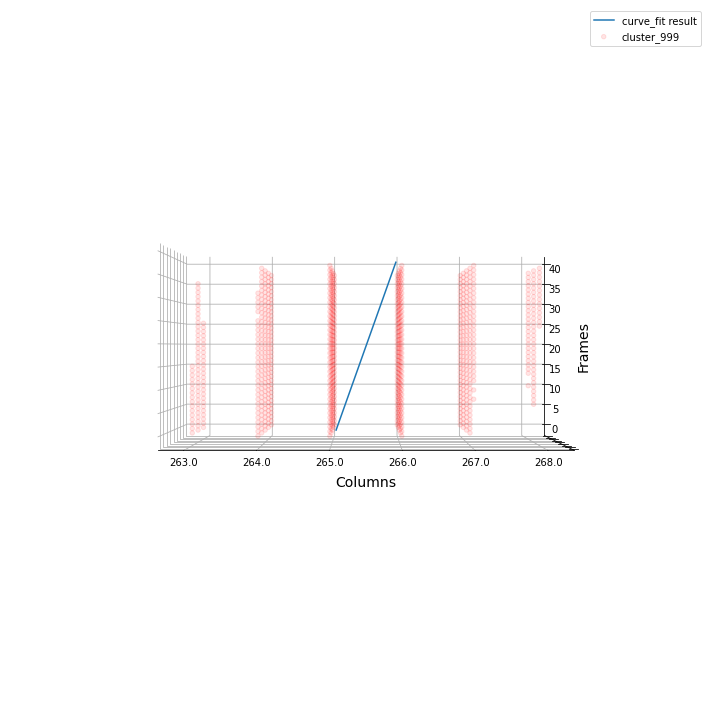

In [35]:
rampused = speedclustercombo(vel = 0.05, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscanf1vp05az90',
                             az = -90, el = 0, flux = 1, colim = 99, cent = 0, mean = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx0.05/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx0.05/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (

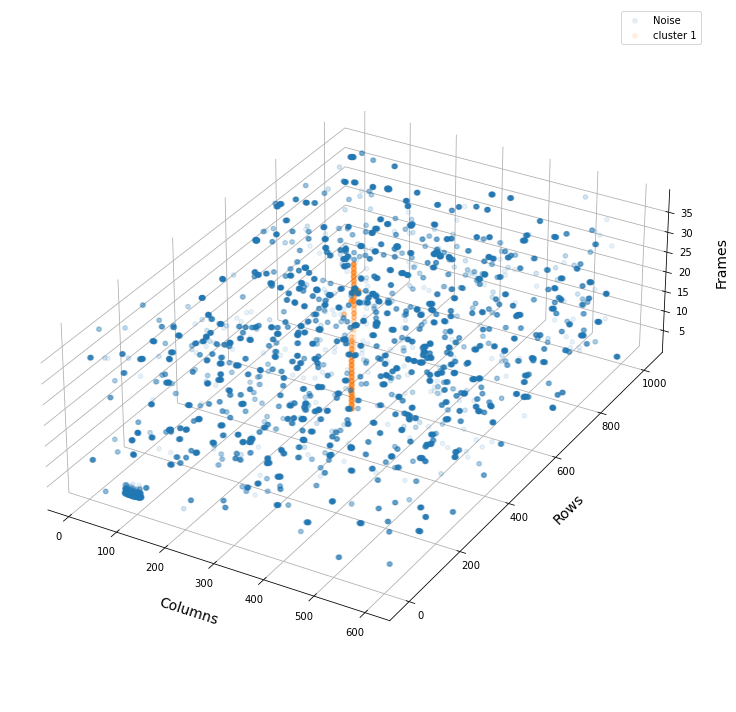

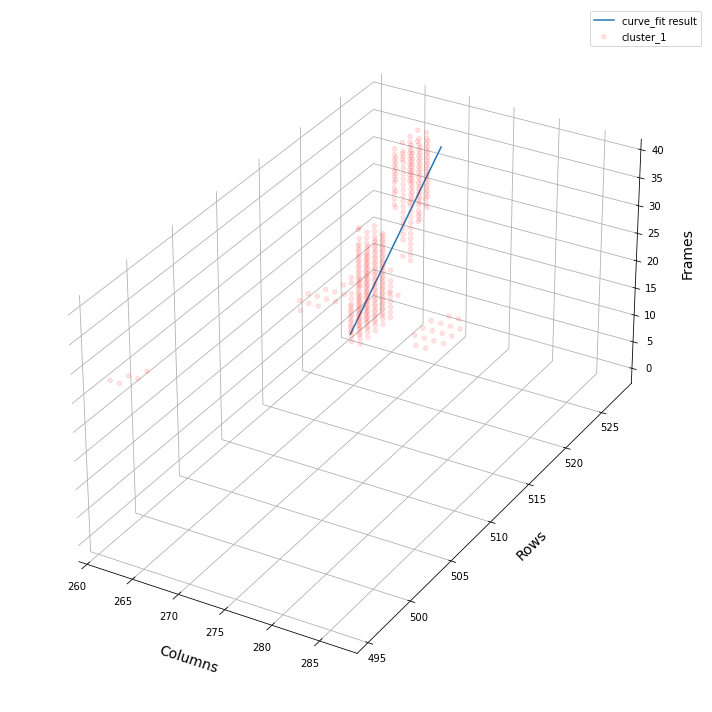

537 486 297 251
(1, 38, 51, 46)
flux cutoff used for defining asteroid core =  368.69289062499956


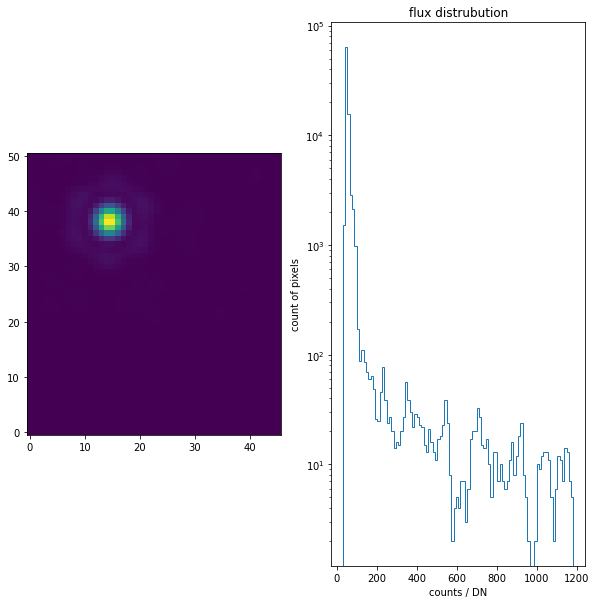

in the flux field for cluster1 optimal slope multiplied by pixel scale and divided by frame time : 0.0009044266
aspect used is : (17, 40, 20.0)


2021-09-14 11:27:32,793 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:311: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



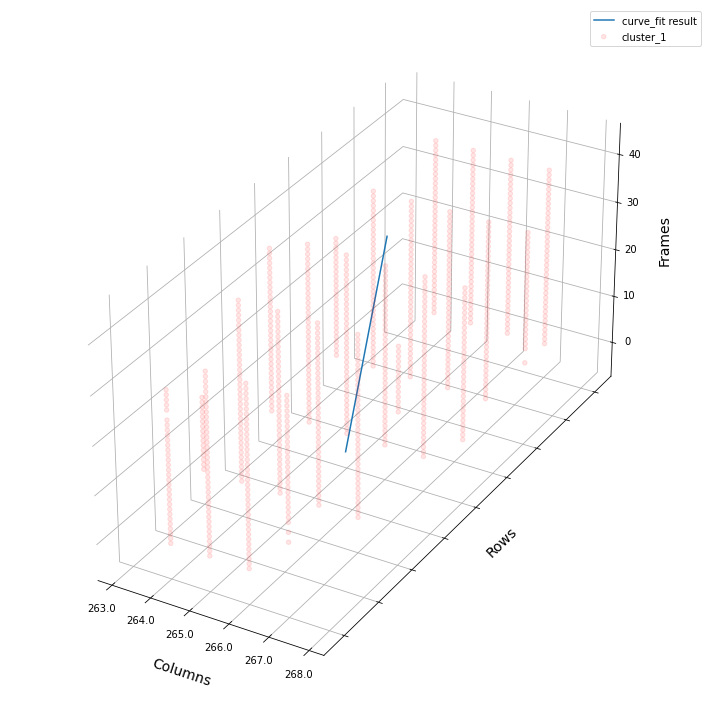

unique values in the data passed to buildsamples are [0 1]
shape of samps array:  (892, 4)
shape of sampss array:  (892, 4)
checking cluster :  1
[0]
Estimated no. of clusters: 1  with labels : [0]
Estimated no. of noise points: 0
number of samples categorised:  (892,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
clusters representing asteroids : [0]
astcluster returned is : [0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.0009044266
aspect used is : (17, 40, 20.0)


2021-09-14 11:27:33,347 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



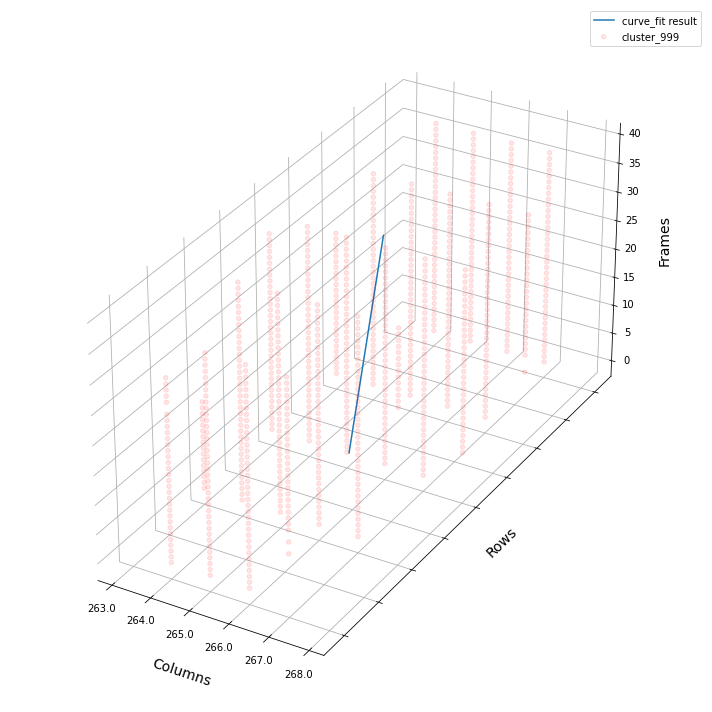

In [18]:
# same speed as above but with different viewing angles
rampused = speedclustercombo(vel = 0.05, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscand1f1vp05', az = -60, el = 30,
                  flux = 1, colim = 99, cent = 0, mean = 1, setat = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx1/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx1/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 

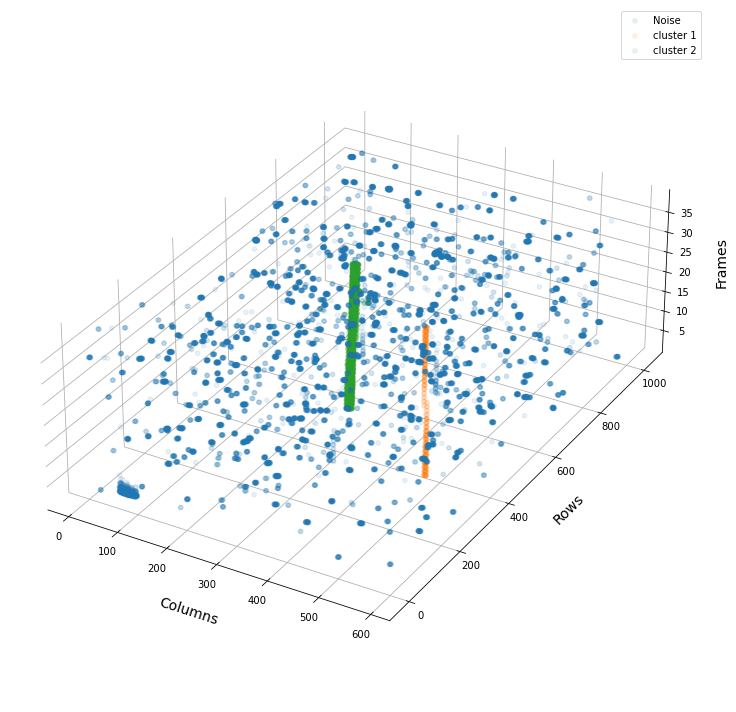

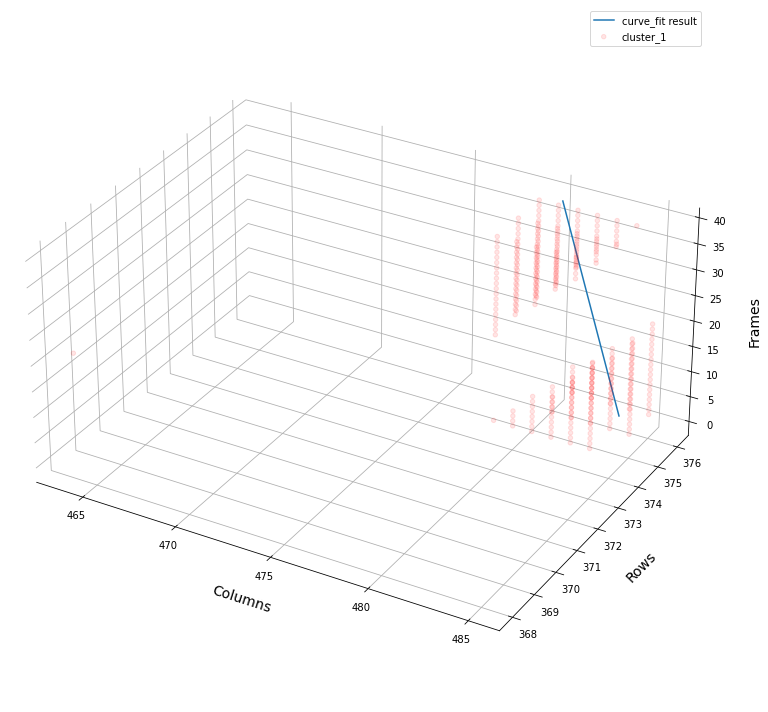

386 358 495 454
(1, 38, 28, 41)
flux cutoff used for defining asteroid core =  55.5771484375


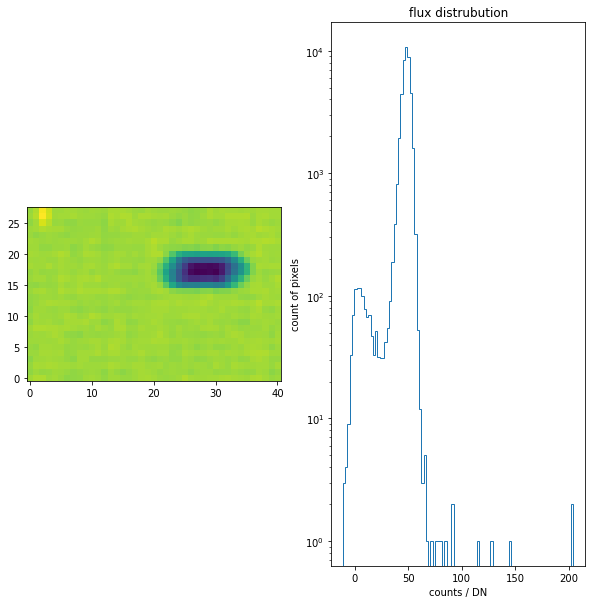

2021-09-14 11:27:38,470 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:311: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



in the flux field for cluster1 optimal slope multiplied by pixel scale and divided by frame time : -0.0052367924
aspect used is : (40, 27, 20.0)


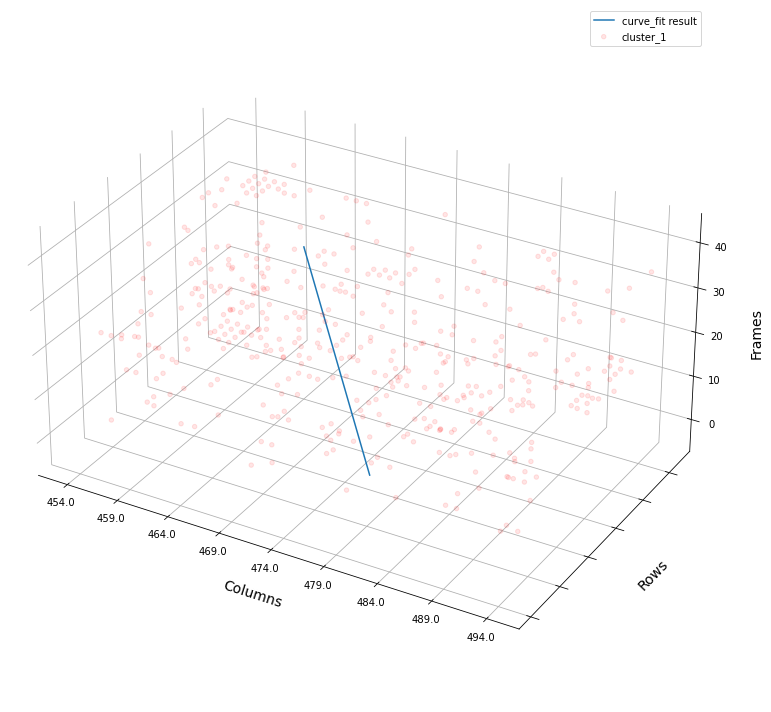

unique values in the data passed to buildsamples are [0 1]
shape of samps array:  (438, 4)
shape of sampss array:  (438, 4)
checking cluster :  1
[]
Estimated no. of clusters: 1  with labels : [-1]
Estimated no. of noise points: 438
number of samples categorised:  (438,)
only one cluster (-1), therefore no asteroid found
premature exit in the cluster loop for cluster  1
checking cluster :  2
in the first fit for cluster2 optimal slope multiplied by pixel scale and divided by frame time : 0.0159775638
aspect used is : (289, 548, 274.0)
ploty is  [526]


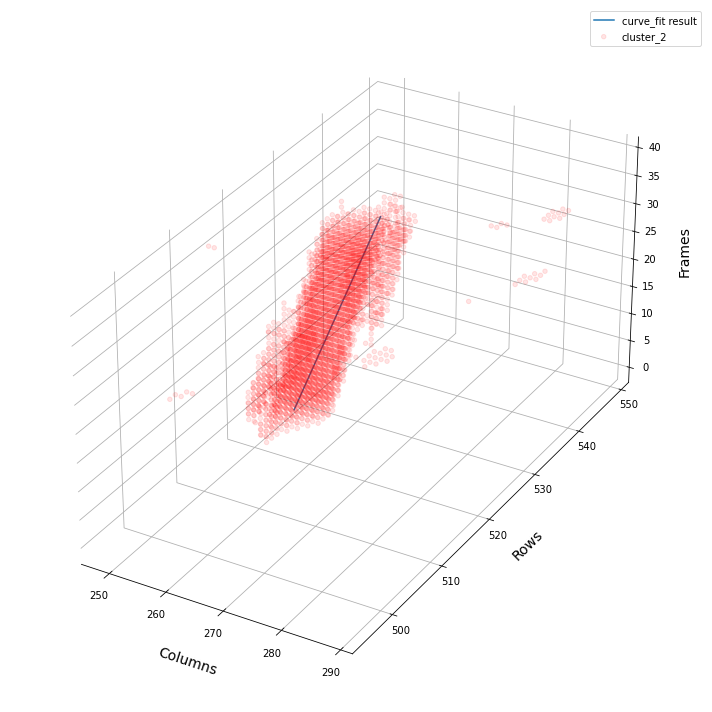

558 486 299 238
(1, 38, 72, 61)
flux cutoff used for defining asteroid core =  135.66152343749945


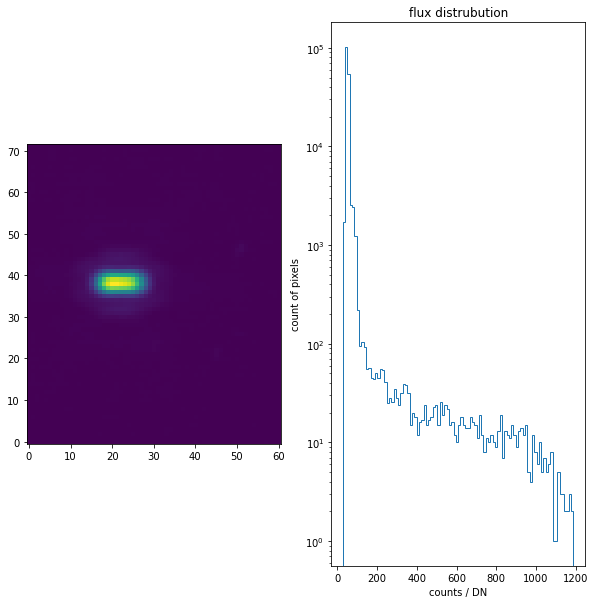

in the flux field for cluster2 optimal slope multiplied by pixel scale and divided by frame time : 0.0117376876
aspect used is : (52, 48, 26.0)


2021-09-14 11:27:40,697 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:311: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



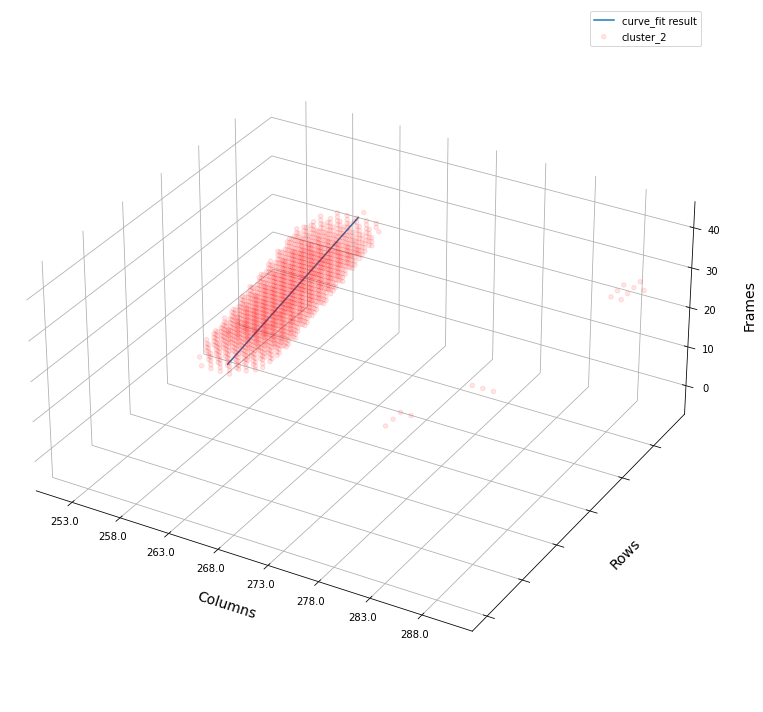

unique values in the data passed to buildsamples are [0 2]
shape of samps array:  (1669, 4)
shape of sampss array:  (1669, 4)
checking cluster :  2
[0]
Estimated no. of clusters: 2  with labels : [-1  0]
Estimated no. of noise points: 15
number of samples categorised:  (1669,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
clusters representing asteroids : [0]
astcluster returned is : [-1  0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.0109728001
aspect used is : (30, 42, 21.0)


2021-09-14 11:27:41,382 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



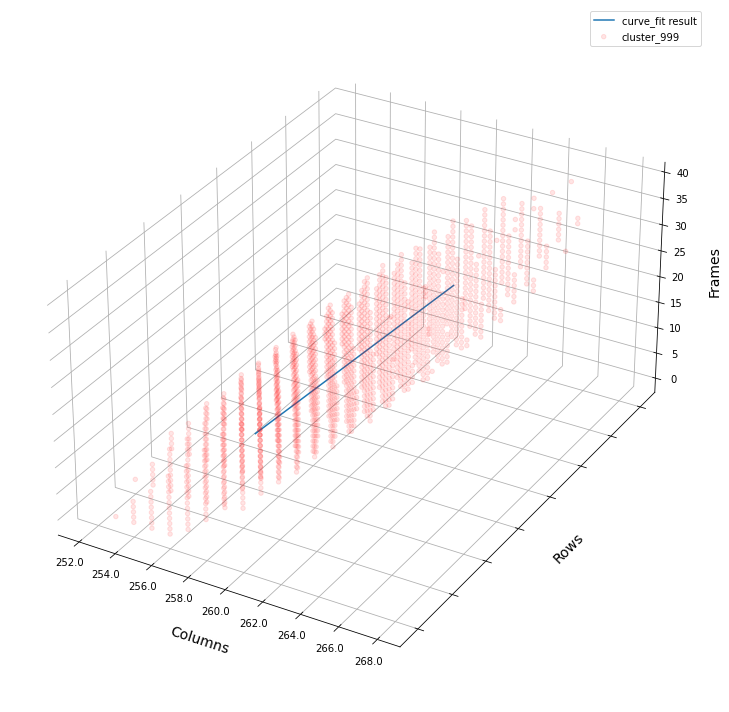

In [19]:
rampused = speedclustercombo(vel = 1, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscand1f1v1', az = -60, el = 30, flux = 1,
                  colim = 99, cent = 0, mean = 1, setat = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx5/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx5/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 

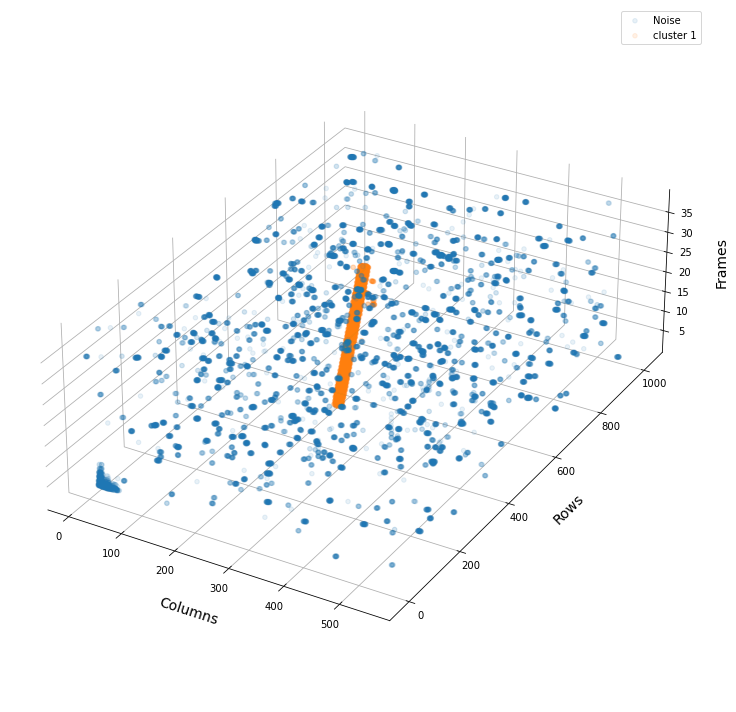

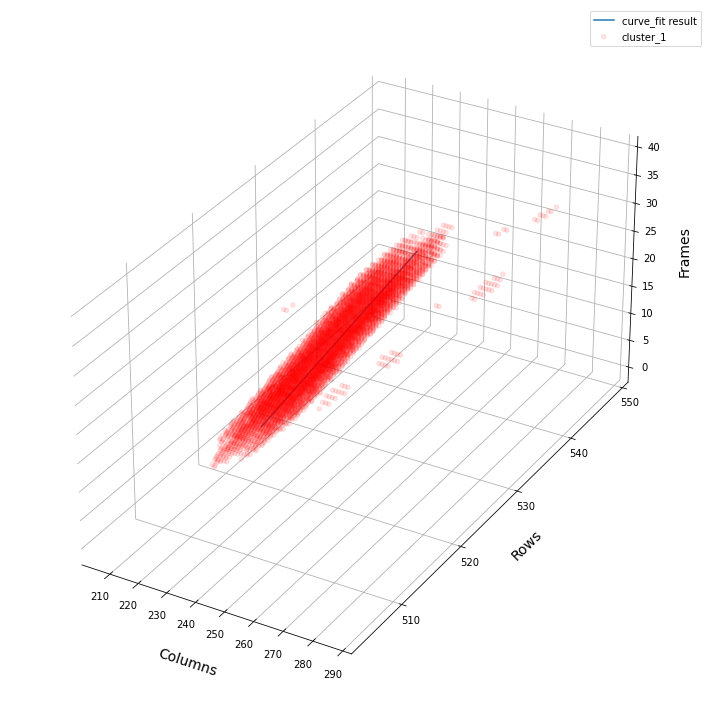

558 495 297 196
(1, 38, 63, 101)
flux cutoff used for defining asteroid core =  92.12184570312508


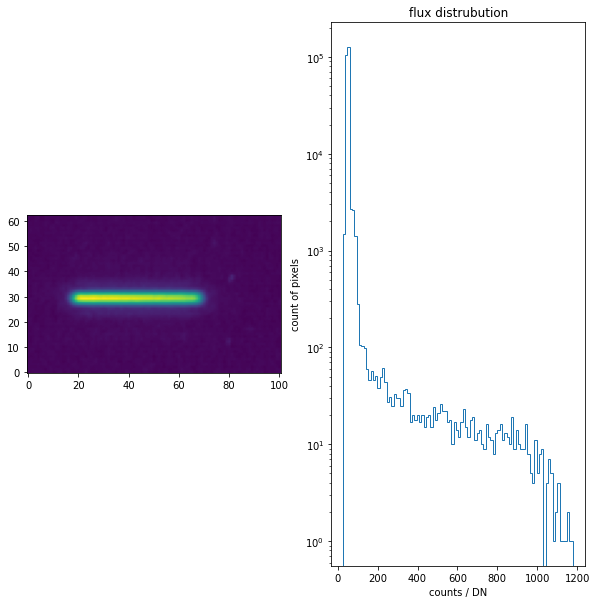

in the flux field for cluster1 optimal slope multiplied by pixel scale and divided by frame time : 0.0557776847
aspect used is : (90, 61, 45.0)


2021-09-14 11:27:47,543 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:311: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



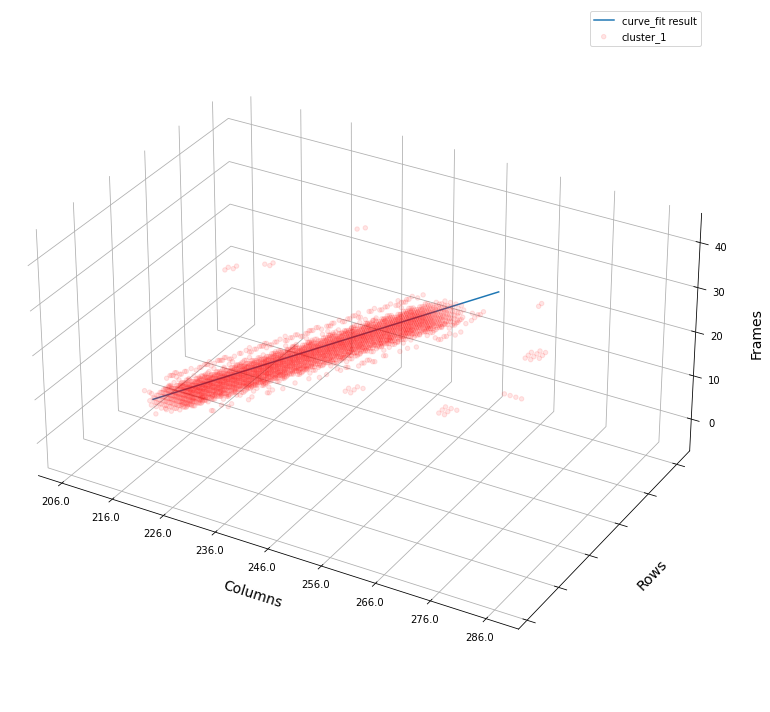

unique values in the data passed to buildsamples are [0 1]
shape of samps array:  (2418, 4)
shape of sampss array:  (2418, 4)
checking cluster :  1
[0]
Estimated no. of clusters: 2  with labels : [-1  0]
Estimated no. of noise points: 130
number of samples categorised:  (2418,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
clusters representing asteroids : [0]
astcluster returned is : [-1  0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.0550199014
aspect used is : (73, 36, 36.5)


2021-09-14 11:27:48,347 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



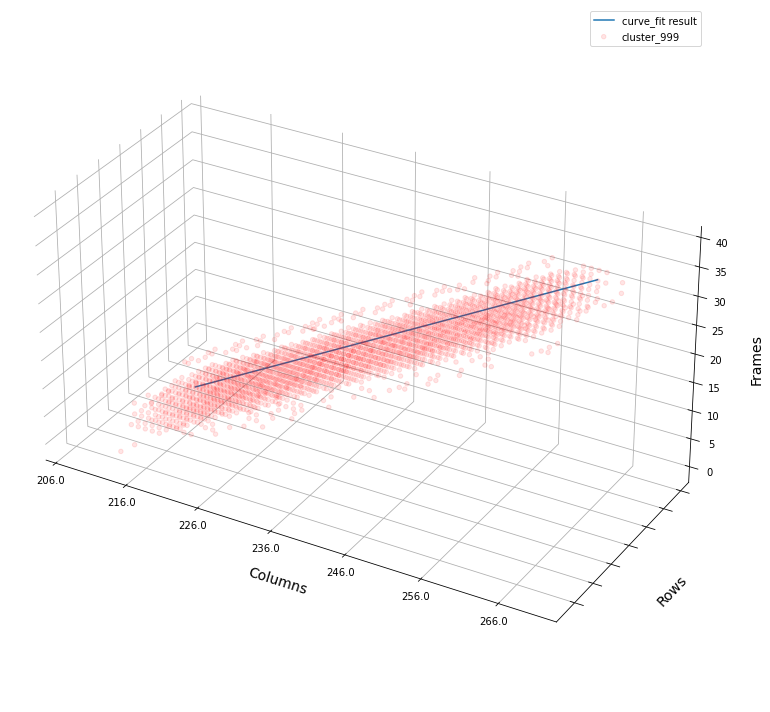

In [20]:
rampused = speedclustercombo(vel = 5, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscand1f1v5', az = -60, el = 30,
                  flux = 1, colim = 99, cent = 0, mean = 1, setat = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx10/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx10/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032

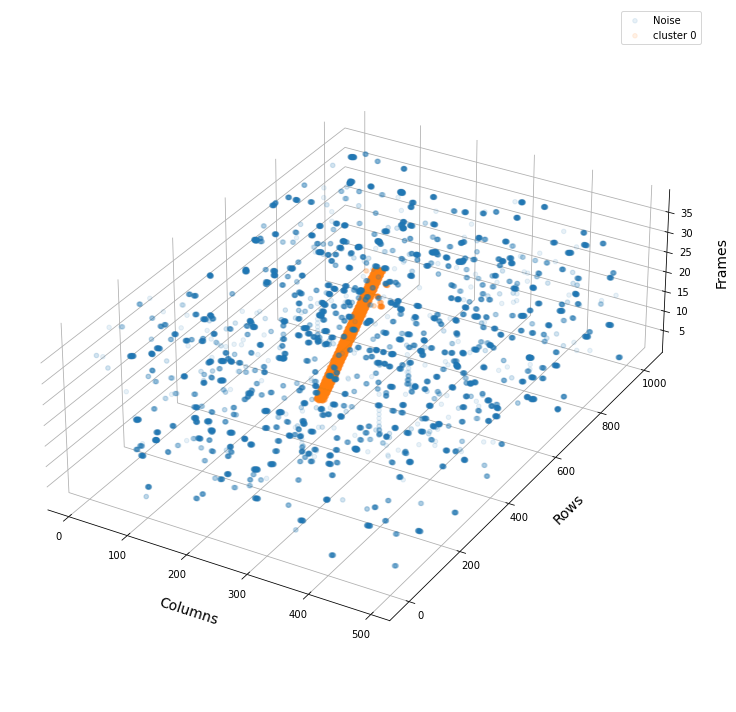

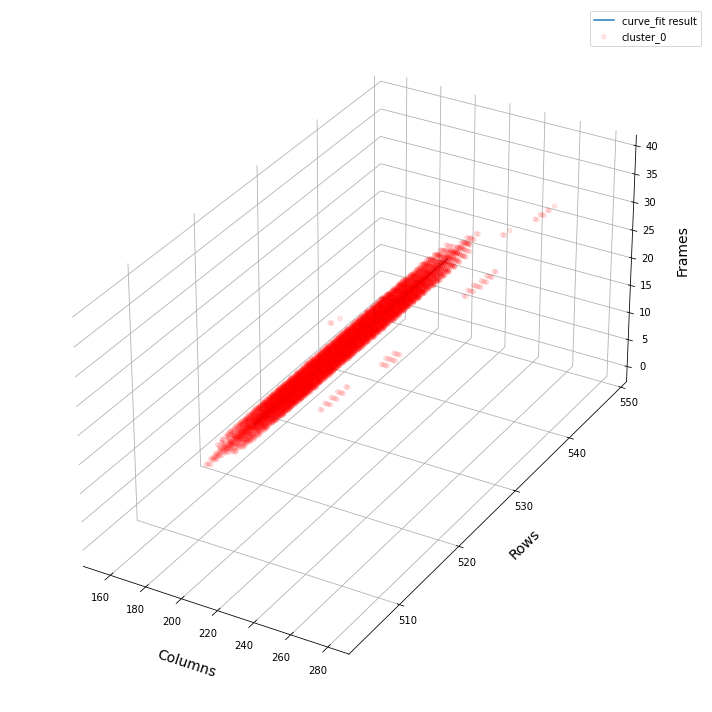

558 495 292 144
(1, 38, 63, 148)
flux cutoff used for defining asteroid core =  83.7724609375


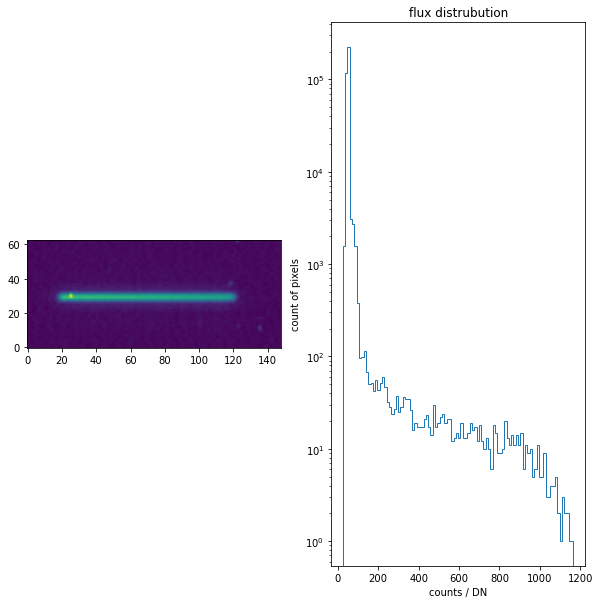

changed cluster number to 999 for ease of application
in the flux field for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.1085280449
aspect used is : (137, 62, 68.5)


2021-09-14 11:27:54,775 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:311: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



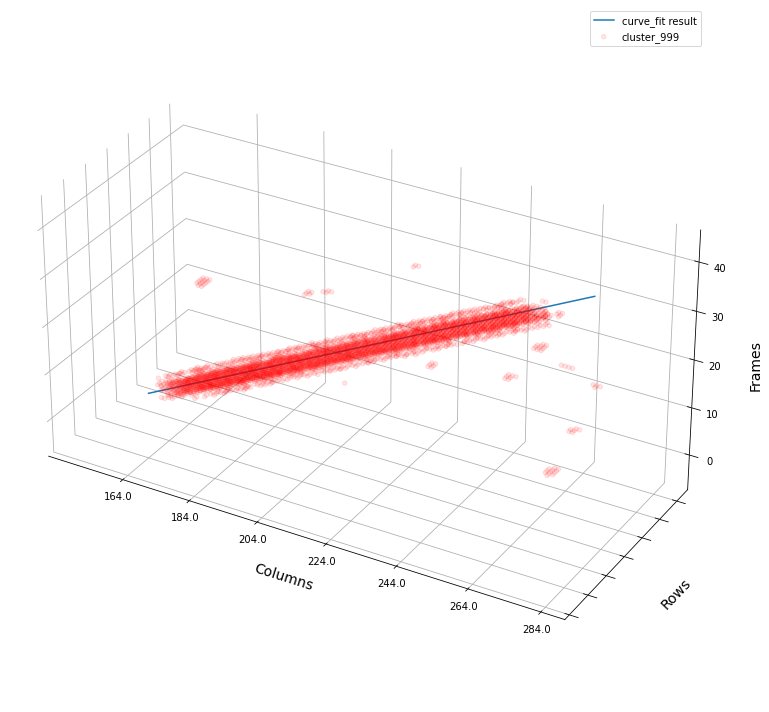

unique values in the data passed to buildsamples are [  0 999]
shape of samps array:  (3545, 4)
shape of sampss array:  (3545, 4)
checking cluster :  999
[0]
Estimated no. of clusters: 2  with labels : [-1  0]
Estimated no. of noise points: 132
number of samples categorised:  (3545,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
clusters representing asteroids : [0]
astcluster returned is : [-1  0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.1096550235
aspect used is : (126, 36, 63.0)


2021-09-14 11:27:55,828 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



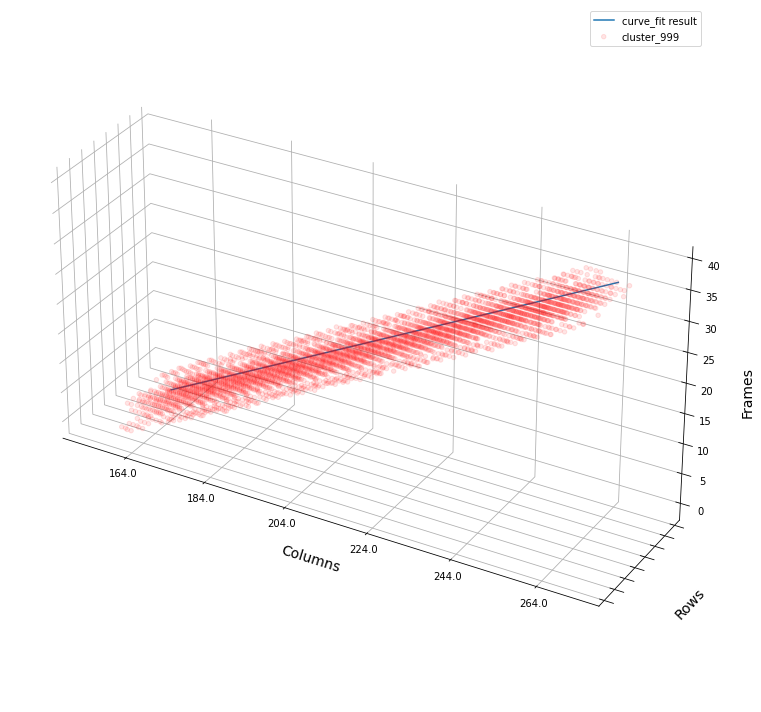

In [21]:
rampused = speedclustercombo(vel = 10, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscand1f1v10', az = -60, el = 30,
                  flux = 1, colim = 99, cent = 0, mean = 1, setat = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx30/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx30/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032

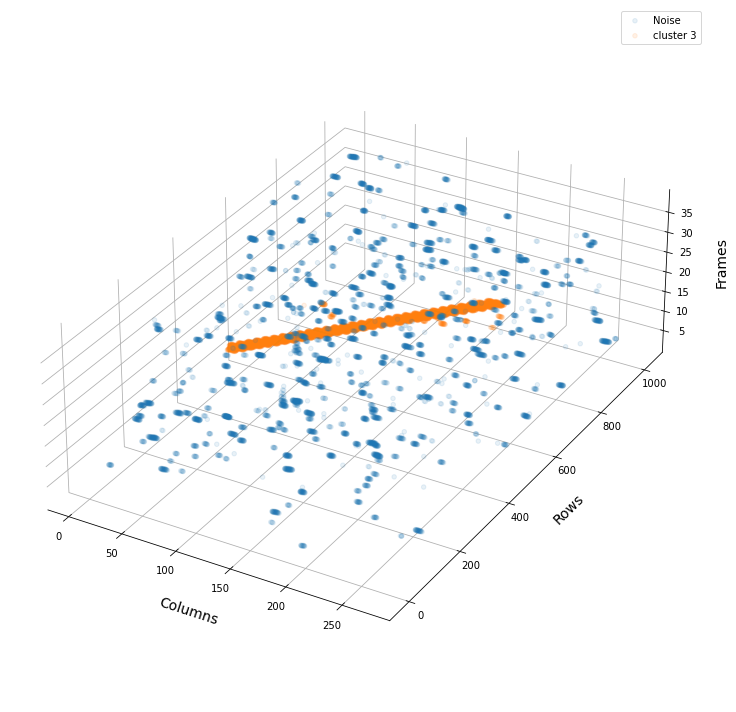

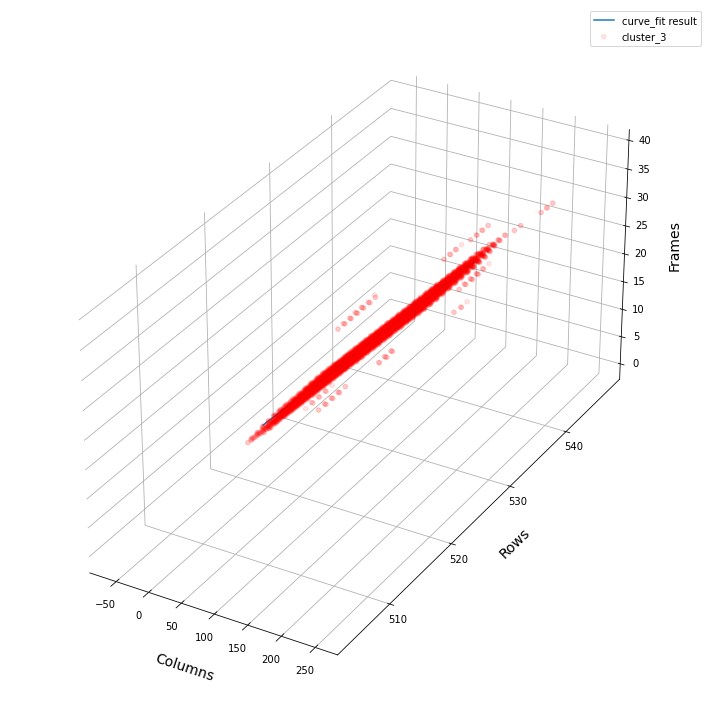

557 495 269 0
(1, 38, 62, 269)
flux cutoff used for defining asteroid core =  67.67425781249995


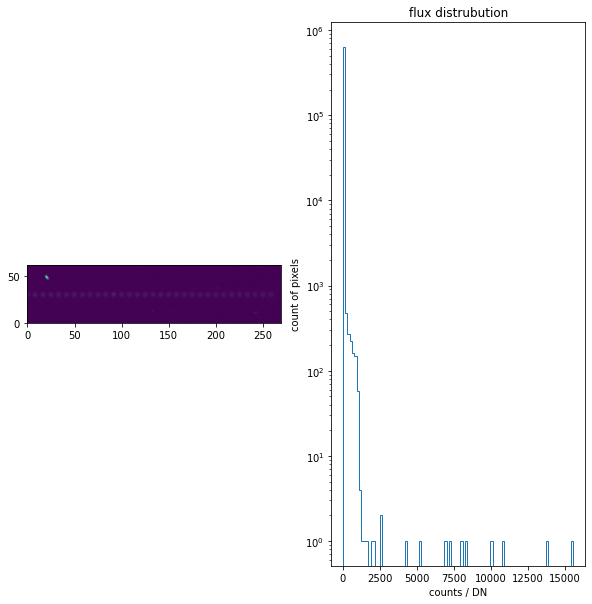

in the flux field for cluster3 optimal slope multiplied by pixel scale and divided by frame time : 0.3054504722
aspect used is : (265, 61, 132.5)


2021-09-14 11:28:00,920 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:311: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



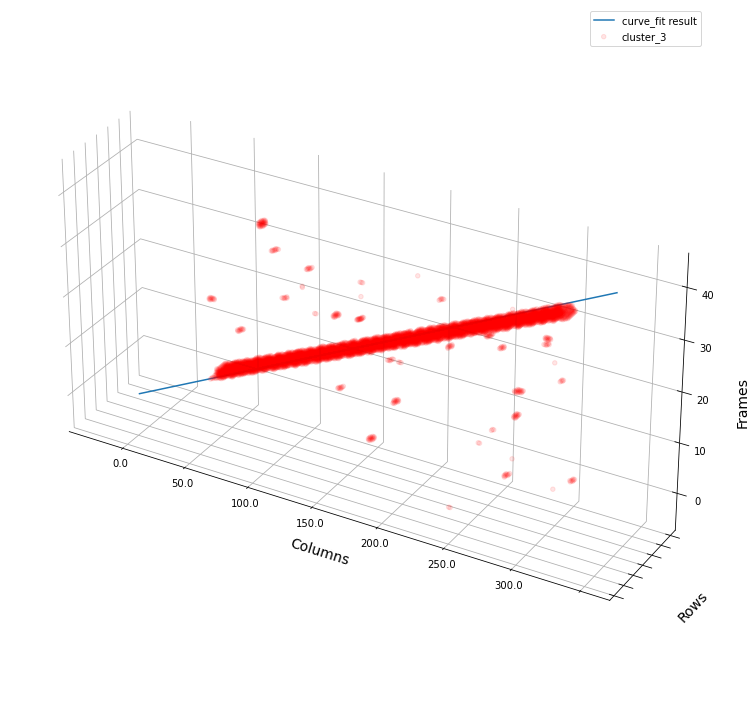

unique values in the data passed to buildsamples are [0 3]
shape of samps array:  (6338, 4)
shape of sampss array:  (6338, 4)
checking cluster :  3
[0 1]
Estimated no. of clusters: 3  with labels : [-1  0  1]
Estimated no. of noise points: 282
number of samples categorised:  (6338,)
range of frames for cluster 0 : 6 37
asteroid detected in cluster 0
range of frames for cluster 1 : 34 34
cluster being dropped due to min frame criteria: 1
clusters representing asteroids : [0]
astcluster returned is : [-1  0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.3294730064
aspect used is : (265, 38, 132.5)


2021-09-14 11:28:02,342 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



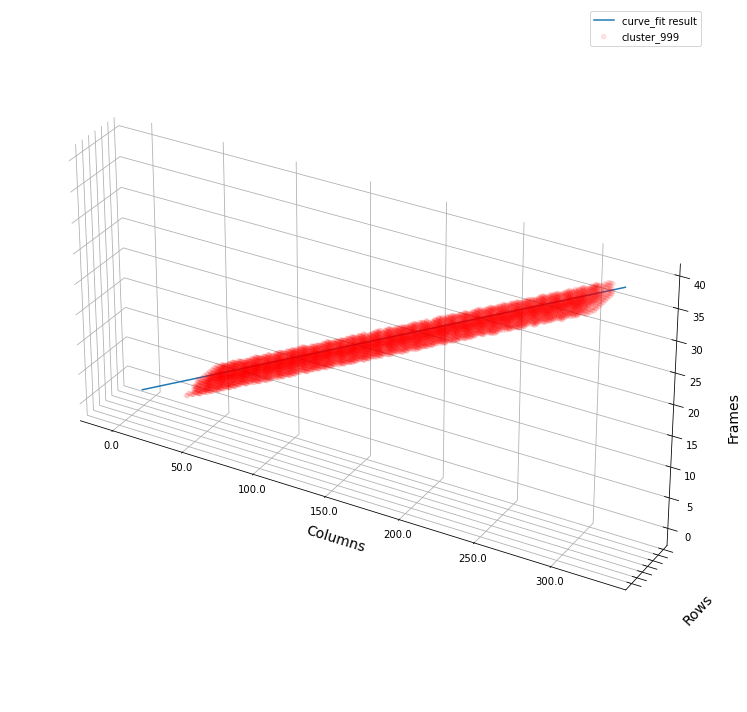

In [22]:
rampused = speedclustercombo(vel = 30, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscand1f1v30', az = -60, el = 30, flux = 1,
                  colim = 99, cent = 0, mean = 1, setat = 1)

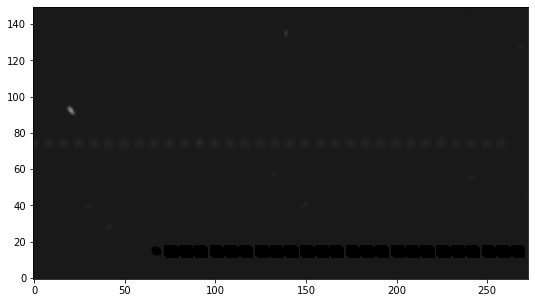

In [23]:
# plot showing the drawback of stella's tool. only works if run right after the previous cell

fig, ax = plt.subplots(1,1,figsize = (10,5))
# ax[0].imshow(rampused[0,0,:,:],origin = 'lower', cmap = 'gist_gray', norm = LogNorm(vmin = 1e4, vmax = 6e4))
ax.imshow(rampused[0,-1,450:600,:],origin = 'lower', cmap = 'gist_gray', norm = LogNorm(vmin = 1e4, vmax = 6e4))
ax.set_facecolor('k')

# xf = 520
# yf = 260

fig.savefig('stellastooldrawback.pdf',format = 'pdf')

# centroid fit

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx0.05/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx0.05/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (

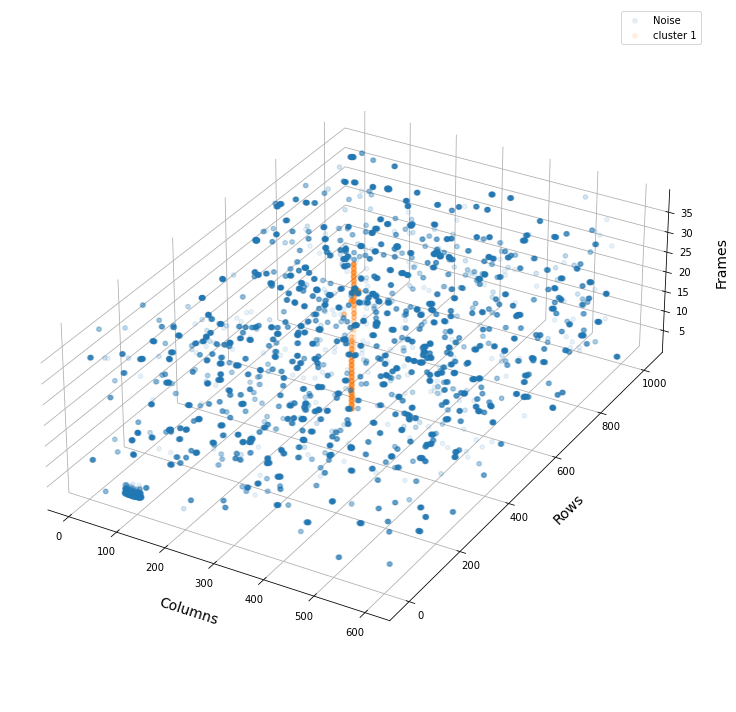

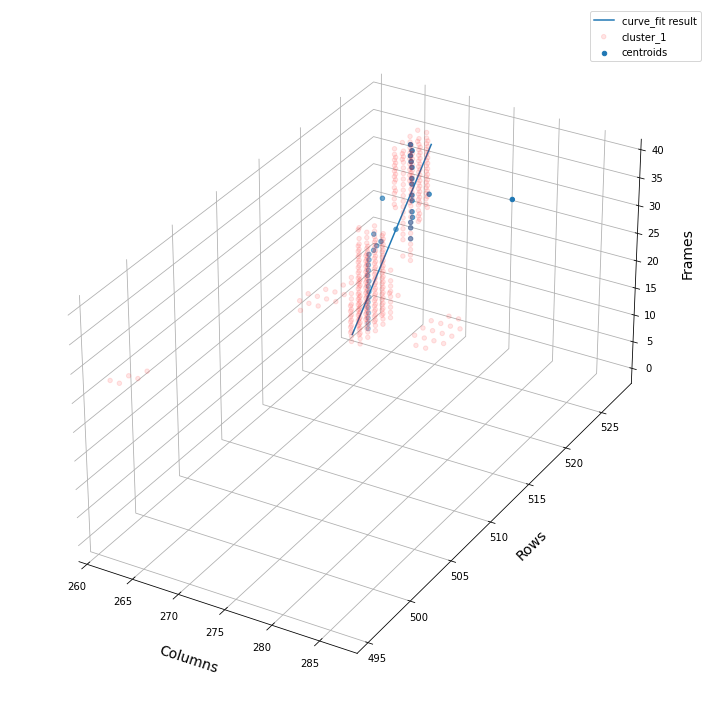

537 486 297 251
flux cutoff used for defining asteroid core =  368.69289062499956


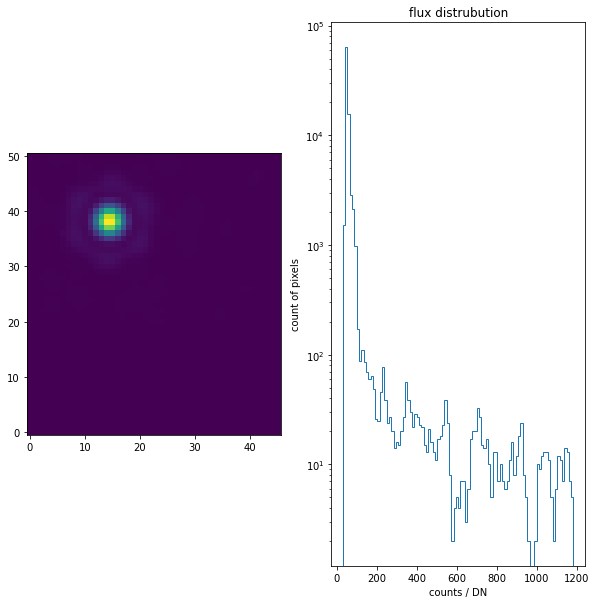

in the flux field for cluster1 optimal slope multiplied by pixel scale and divided by frame time : 0.0009076403
aspect used is : (17, 40, 20.0)


2021-09-14 11:28:07,903 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



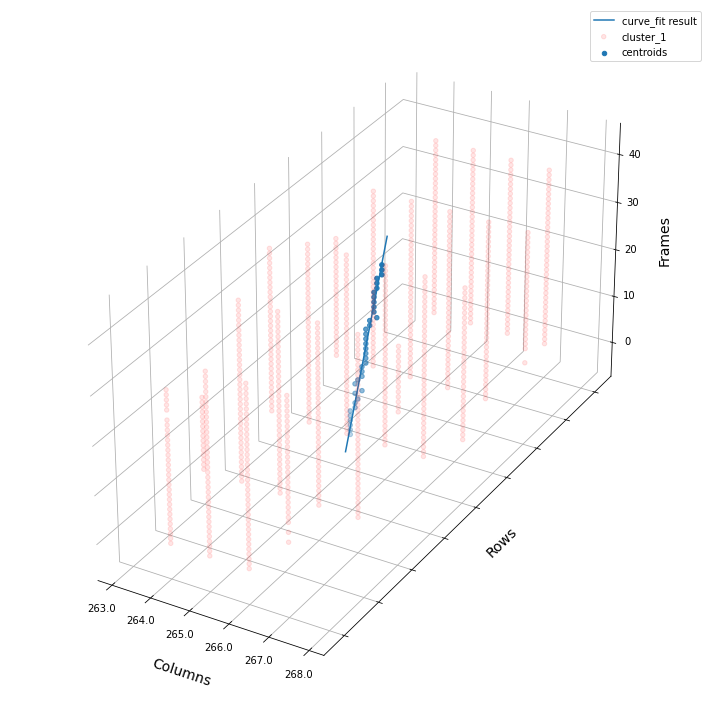

unique values in the data passed to buildsamples are [0 1]
shape of samps array:  (892, 4)
shape of sampss array:  (892, 4)
checking cluster :  <function cluster at 0x7f1362b1e5e0>
[0]
Estimated no. of clusters: 1  with labels : [0]
Estimated no. of noise points: 0
number of samples categorised:  (892,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
clusters representing asteroids : [0]
astcluster returned is : [0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.0009076403
aspect used is : (17, 40, 20.0)


2021-09-14 11:28:08,479 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



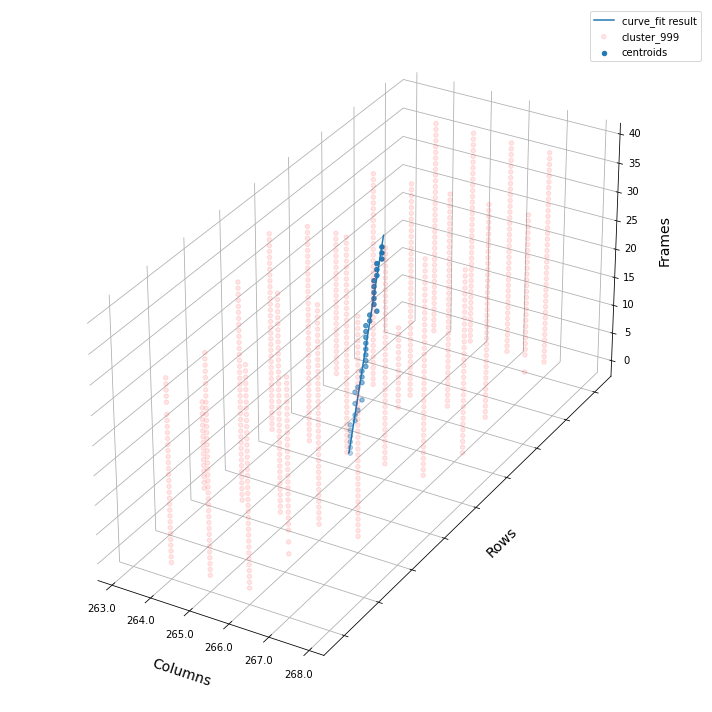

In [24]:
rampused = speedclustercombo(vel = 0.05, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscanf1vp05cent', az = -60,
                  el = 30, flux = 1, colim = 99, cent = 1, mean = 1, setat = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx1/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx1/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 

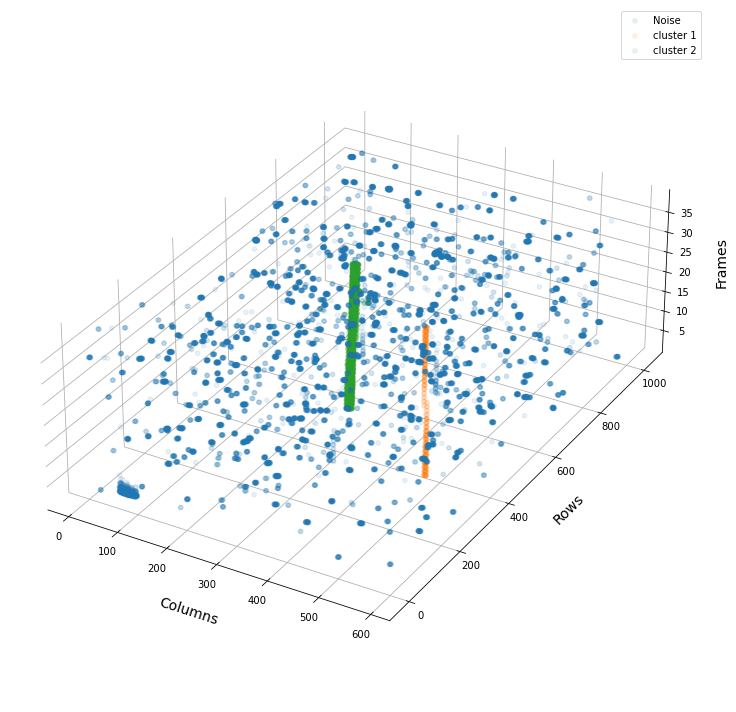

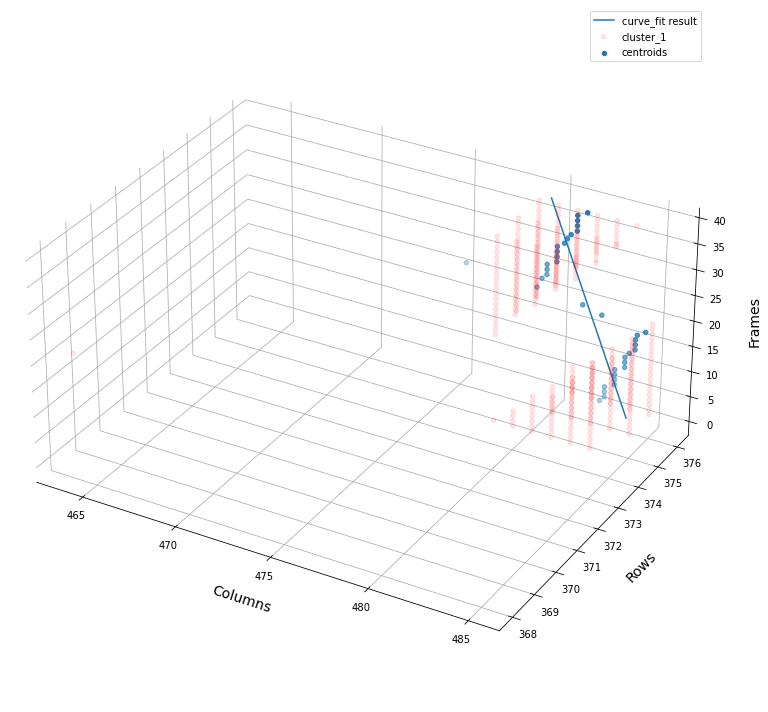

386 358 495 454
flux cutoff used for defining asteroid core =  55.5771484375


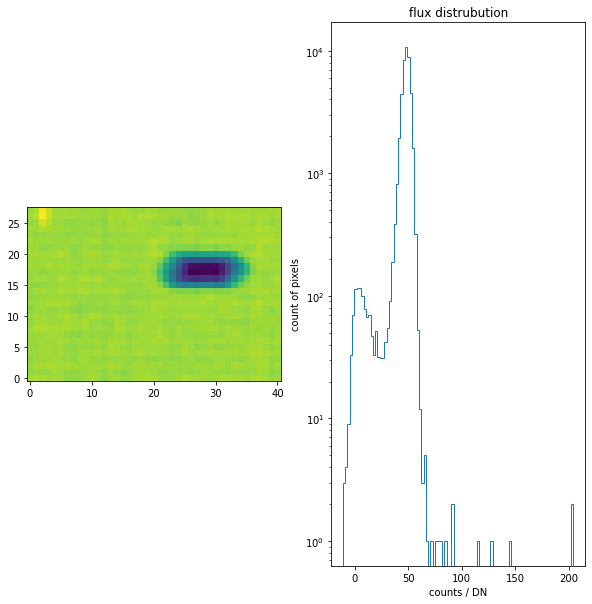

2021-09-14 11:28:14,030 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



in the flux field for cluster1 optimal slope multiplied by pixel scale and divided by frame time : -0.0061728094
aspect used is : (40, 27, 20.0)


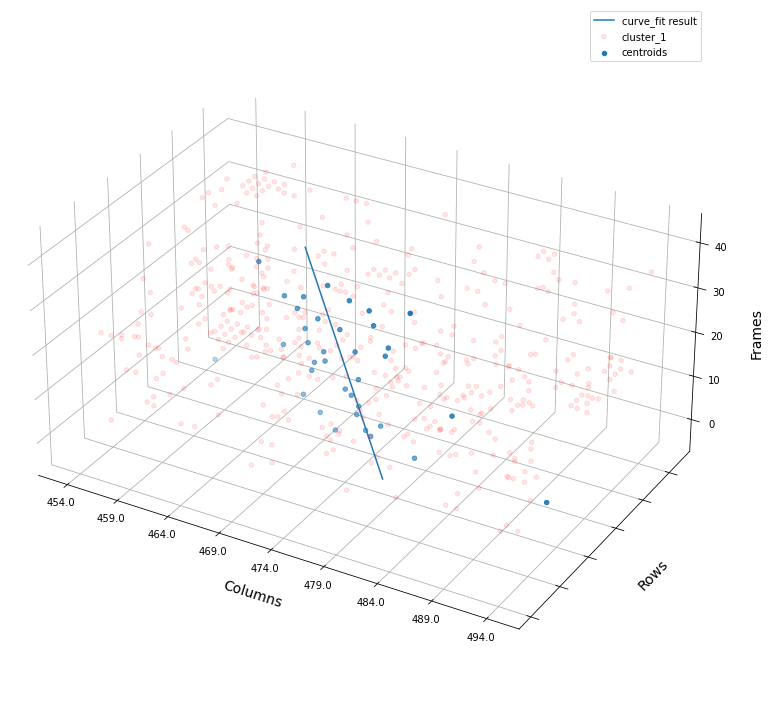

unique values in the data passed to buildsamples are [0 1]
shape of samps array:  (438, 4)
shape of sampss array:  (438, 4)
checking cluster :  <function cluster at 0x7f1362b1e5e0>
[]
Estimated no. of clusters: 1  with labels : [-1]
Estimated no. of noise points: 438
number of samples categorised:  (438,)
only one cluster (-1), therefore no asteroid found
premature exit in the cluster loop for cluster  1
checking cluster :  2
in the first fit for cluster2 optimal slope multiplied by pixel scale and divided by frame time : 0.0159703023
aspect used is : (289, 548, 274.0)
ploty is  [526]


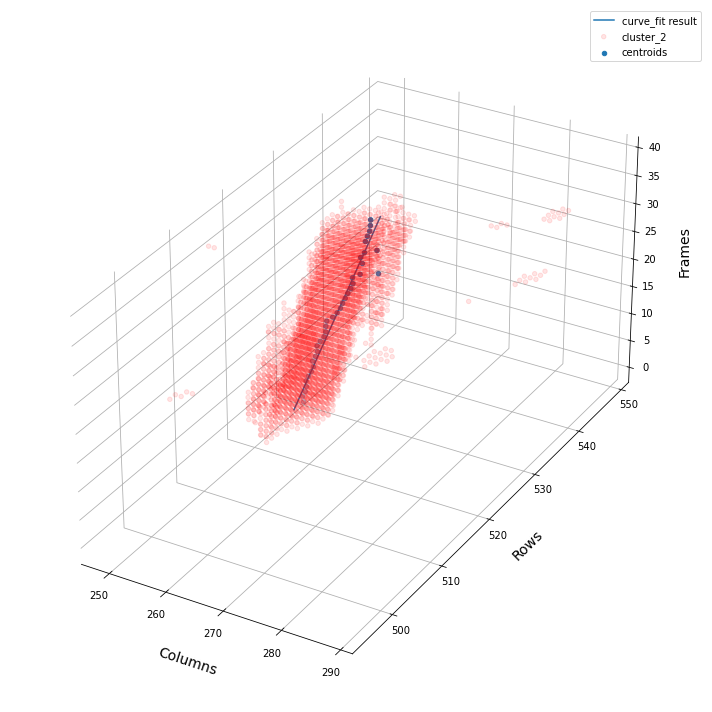

558 486 299 238
flux cutoff used for defining asteroid core =  135.66152343749945


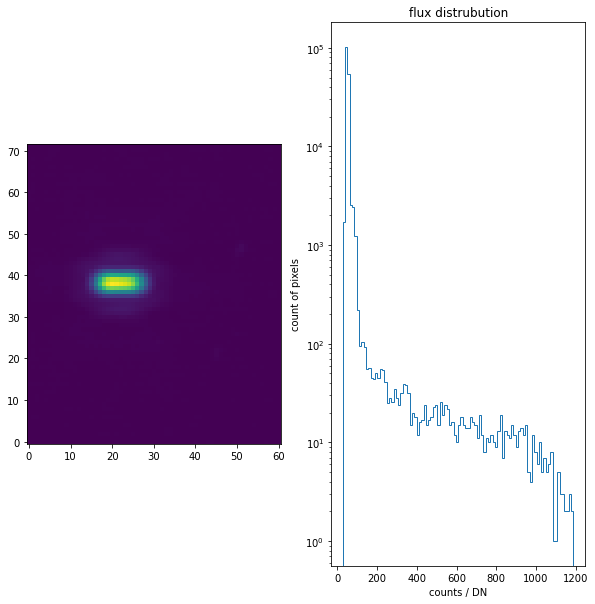

in the flux field for cluster2 optimal slope multiplied by pixel scale and divided by frame time : 0.0116687668
aspect used is : (52, 48, 26.0)


2021-09-14 11:28:16,291 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



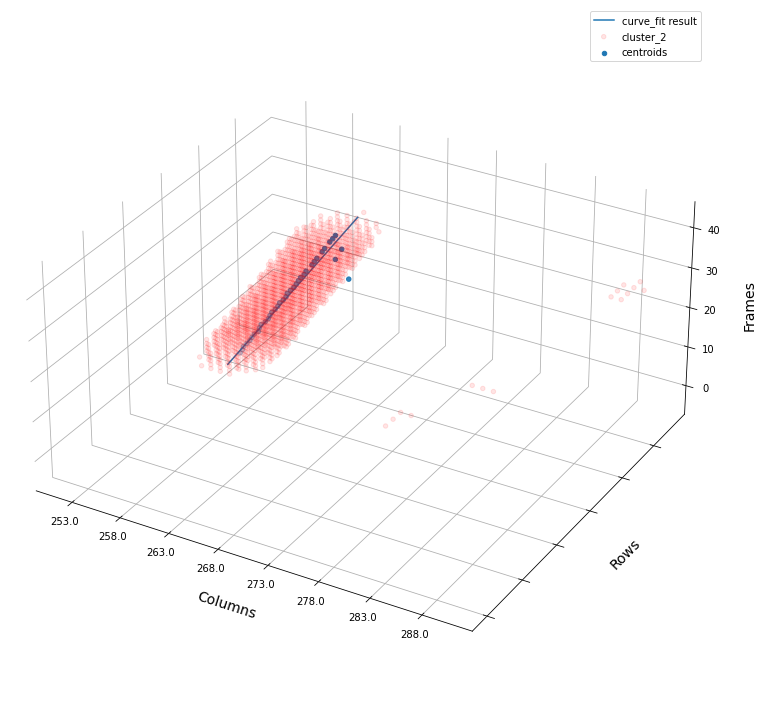

unique values in the data passed to buildsamples are [0 2]
shape of samps array:  (1669, 4)
shape of sampss array:  (1669, 4)
checking cluster :  <function cluster at 0x7f1362b1e5e0>
[0]
Estimated no. of clusters: 2  with labels : [-1  0]
Estimated no. of noise points: 15
number of samples categorised:  (1669,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
clusters representing asteroids : [0]
astcluster returned is : [-1  0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.010972208
aspect used is : (30, 42, 21.0)


2021-09-14 11:28:17,035 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



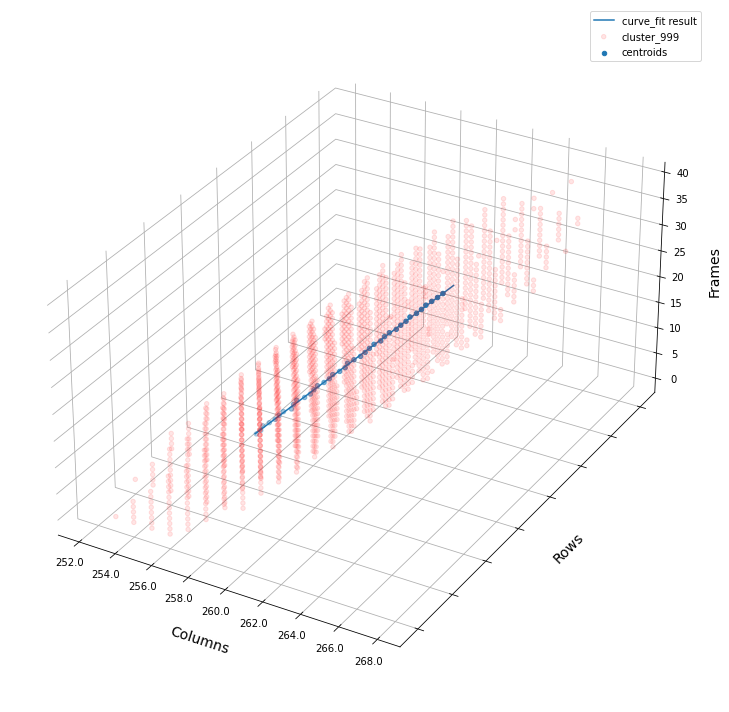

In [25]:
rampused = speedclustercombo(vel = 1, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscanf1v1cent', az = -60, el = 30,
                  flux = 1, colim = 99, cent = 1, mean = 1, setat = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx5/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx5/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 

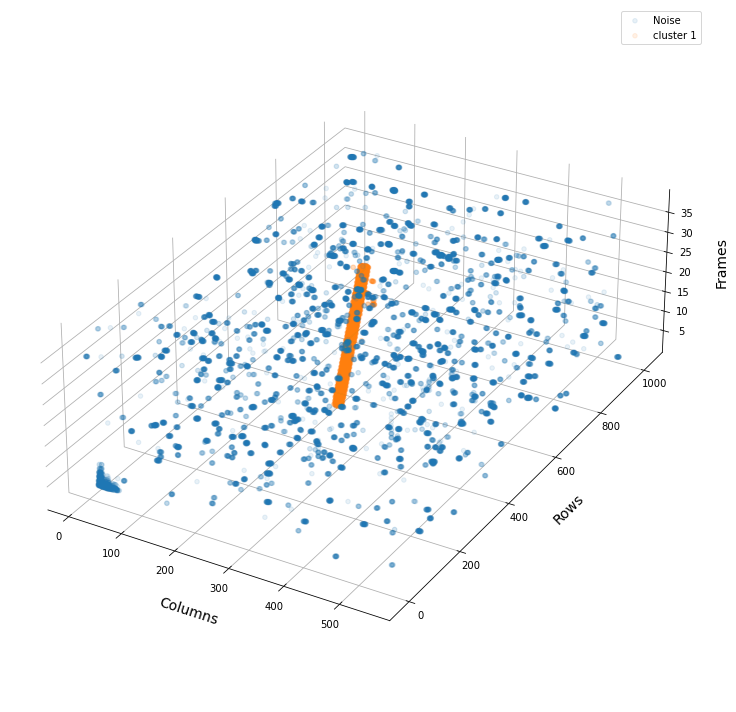

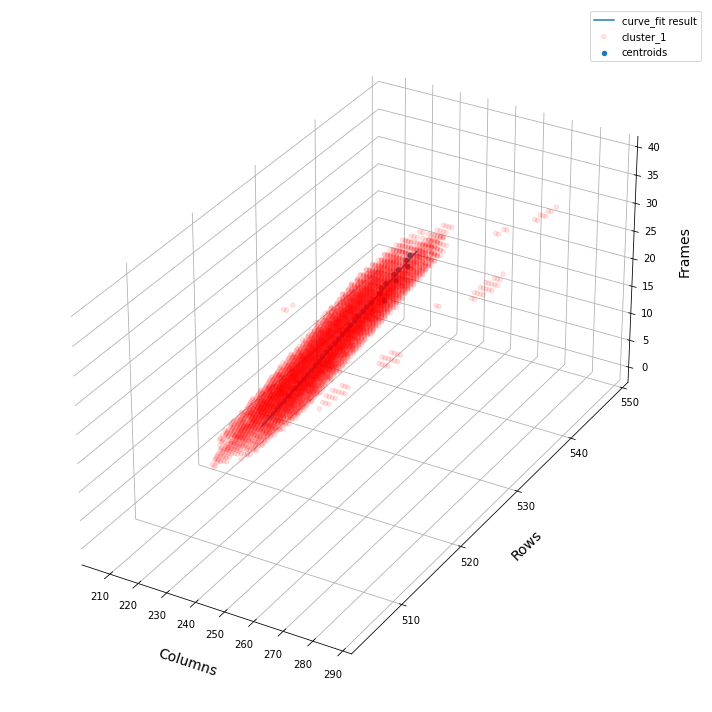

558 495 297 196
flux cutoff used for defining asteroid core =  92.12184570312508


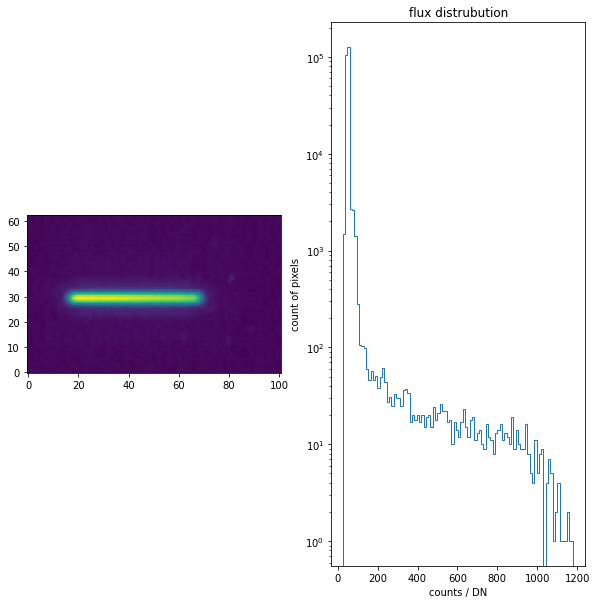

in the flux field for cluster1 optimal slope multiplied by pixel scale and divided by frame time : 0.0556905397
aspect used is : (90, 61, 45.0)


2021-09-14 11:28:23,688 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



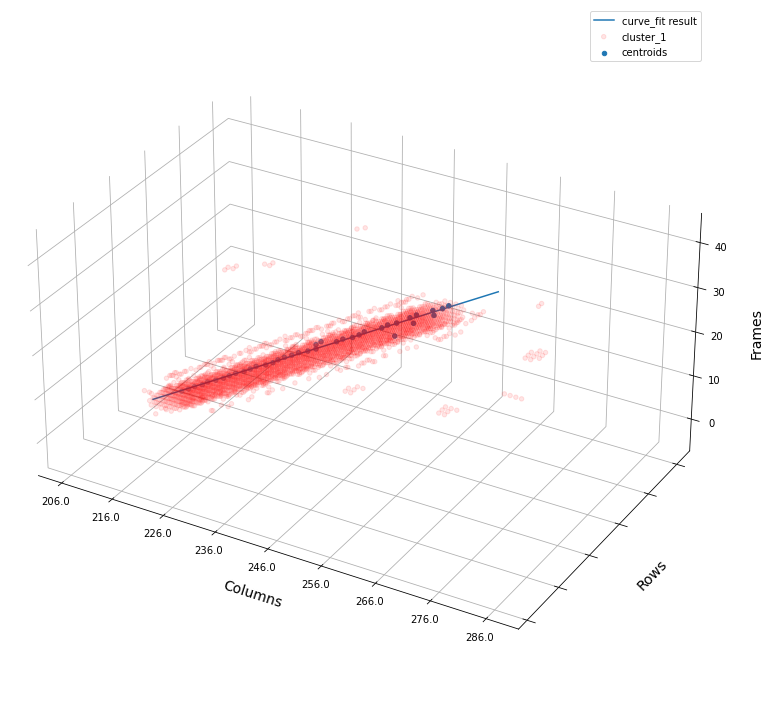

unique values in the data passed to buildsamples are [0 1]
shape of samps array:  (2418, 4)
shape of sampss array:  (2418, 4)
checking cluster :  <function cluster at 0x7f1362b1e5e0>
[0]
Estimated no. of clusters: 2  with labels : [-1  0]
Estimated no. of noise points: 130
number of samples categorised:  (2418,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
clusters representing asteroids : [0]
astcluster returned is : [-1  0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.0550121382
aspect used is : (73, 36, 36.5)


2021-09-14 11:28:24,571 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



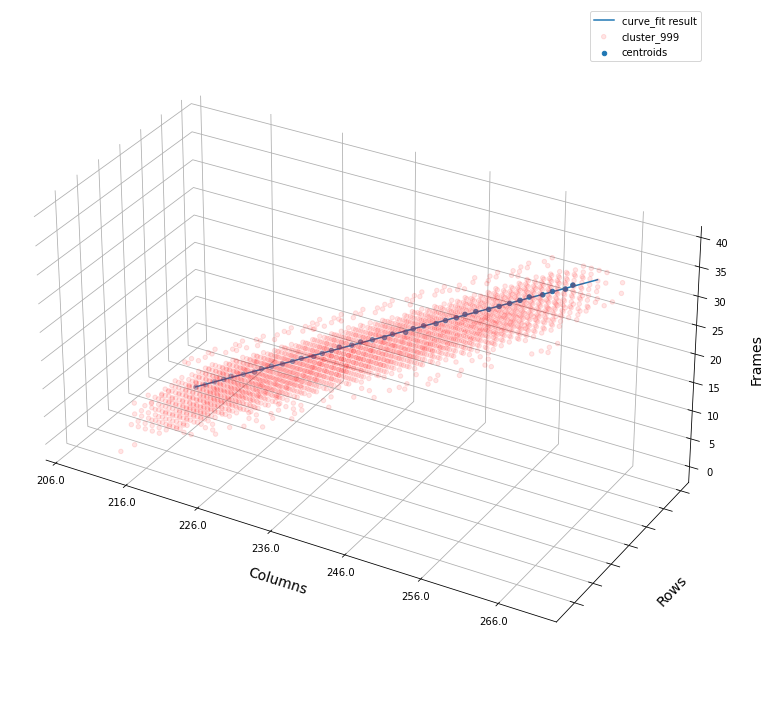

In [26]:
rampused = speedclustercombo(vel = 5, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscanf1v5cent', az = -60, el = 30,
                  flux = 1, colim = 99, cent = 1, mean = 1, setat = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx10/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx10/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032

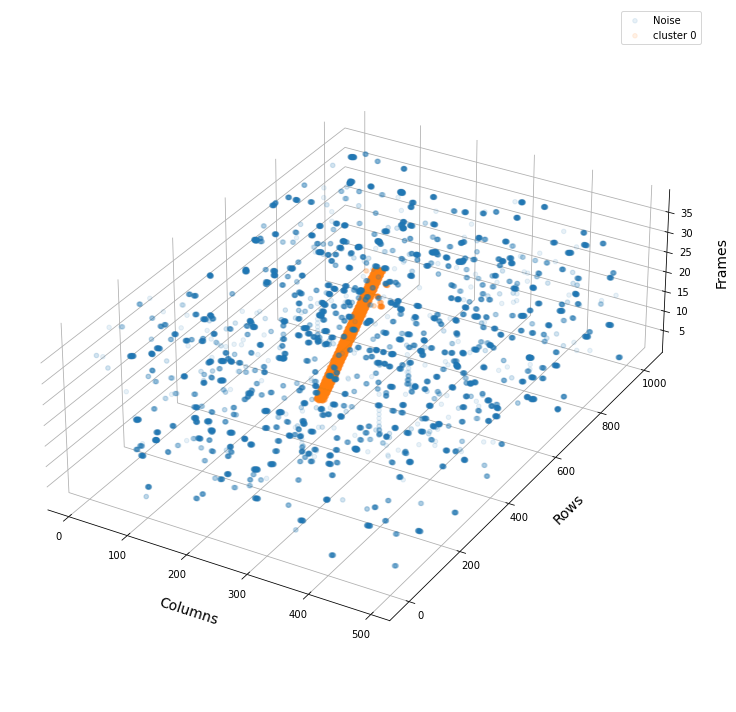

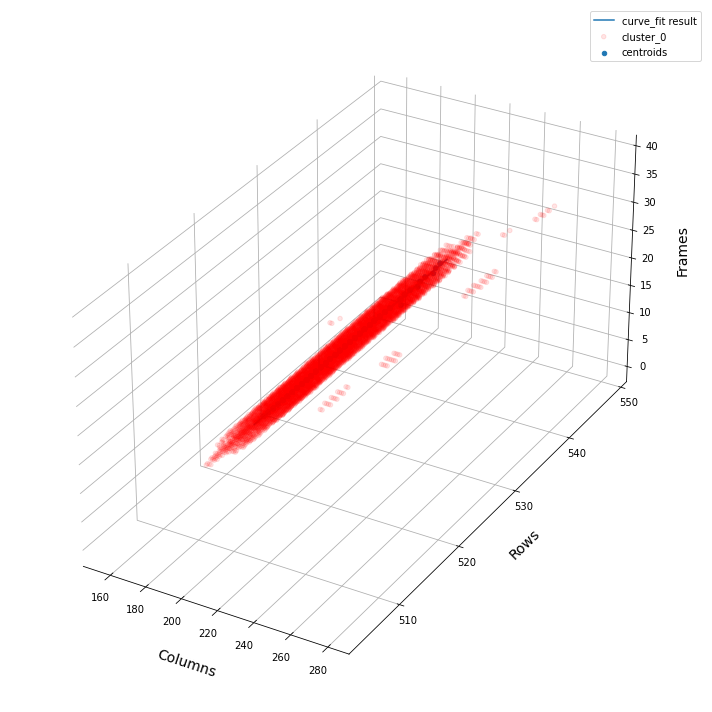

558 495 292 144
flux cutoff used for defining asteroid core =  83.7724609375


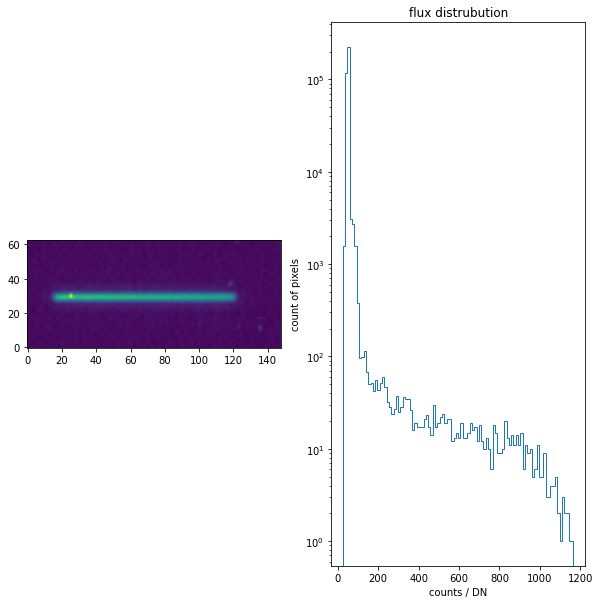

changed cluster number to 999 for ease of application
in the flux field for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.1086766434
aspect used is : (137, 62, 68.5)


2021-09-14 11:28:30,993 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



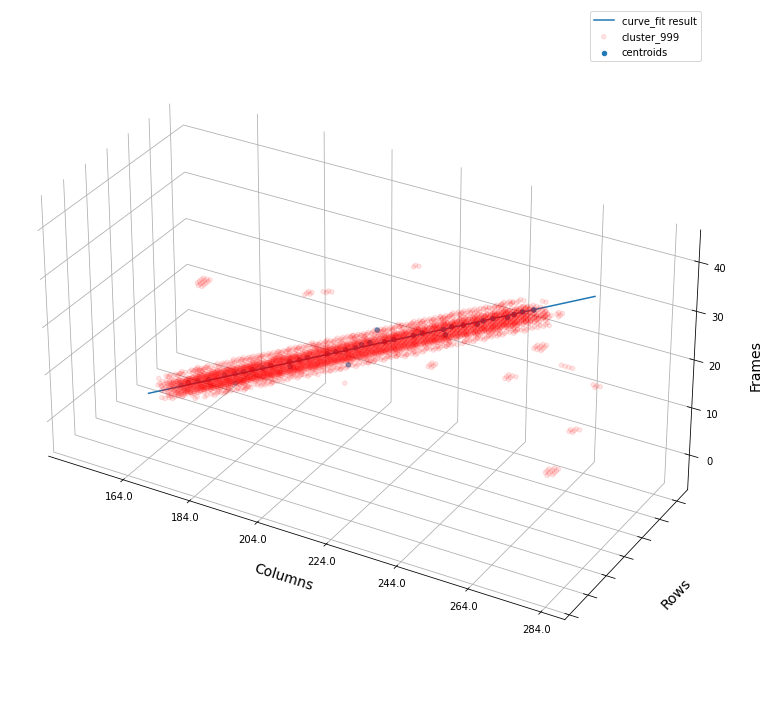

unique values in the data passed to buildsamples are [  0 999]
shape of samps array:  (3545, 4)
shape of sampss array:  (3545, 4)
checking cluster :  <function cluster at 0x7f1362b1e5e0>
[0]
Estimated no. of clusters: 2  with labels : [-1  0]
Estimated no. of noise points: 132
number of samples categorised:  (3545,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
clusters representing asteroids : [0]
astcluster returned is : [-1  0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.1096442839
aspect used is : (126, 36, 63.0)


2021-09-14 11:28:31,984 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



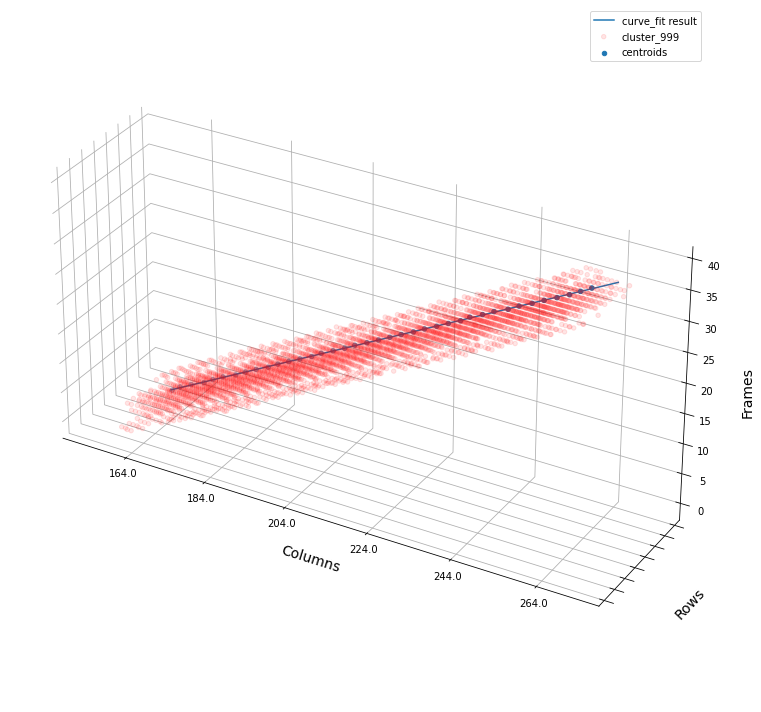

In [27]:
rampused = speedclustercombo(vel = 10, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscanf1v10cent', az = -60, el = 30,
                  flux = 1, colim = 99, cent = 1, mean = 1, setat = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx30/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx30/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032

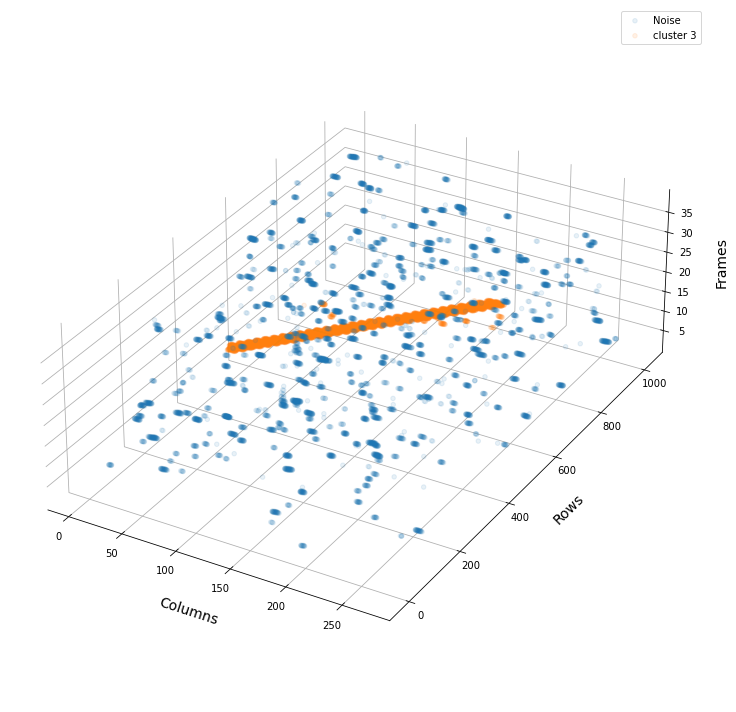

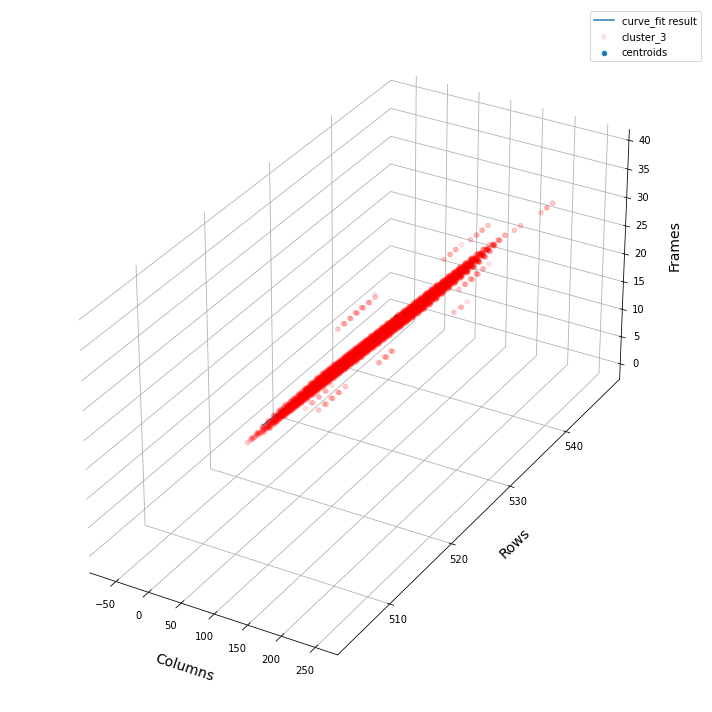

557 495 269 0
flux cutoff used for defining asteroid core =  67.67425781249995


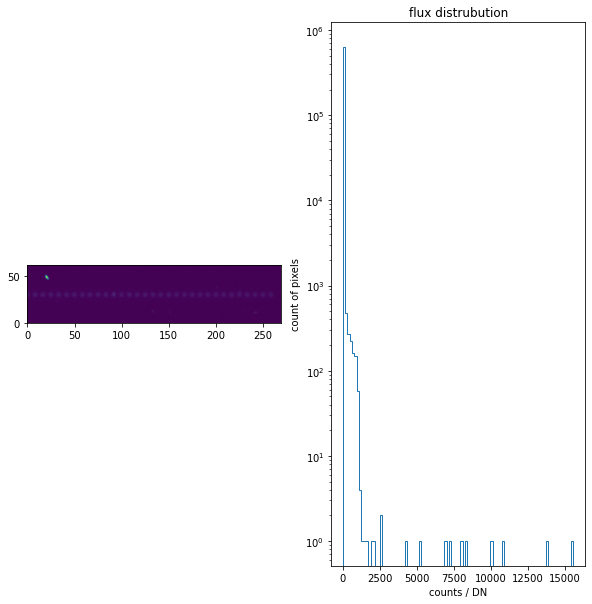

in the flux field for cluster3 optimal slope multiplied by pixel scale and divided by frame time : 0.1561934732
aspect used is : (265, 61, 132.5)


2021-09-14 11:28:37,316 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



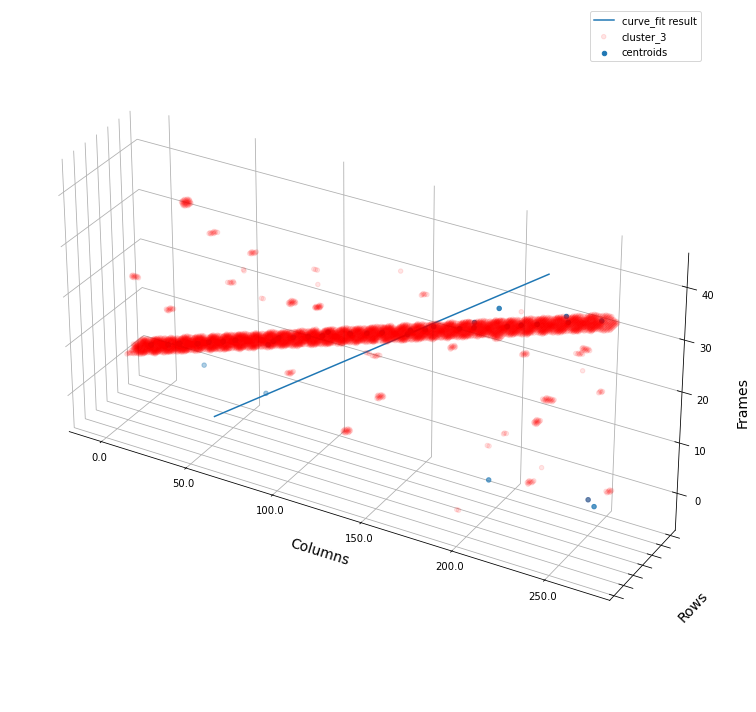

unique values in the data passed to buildsamples are [0 3]
shape of samps array:  (6338, 4)
shape of sampss array:  (6338, 4)
checking cluster :  <function cluster at 0x7f1362b1e5e0>
[0 1]
Estimated no. of clusters: 3  with labels : [-1  0  1]
Estimated no. of noise points: 282
number of samples categorised:  (6338,)
range of frames for cluster 0 : 6 37
asteroid detected in cluster 0
range of frames for cluster 1 : 34 34
cluster being dropped due to min frame criteria: 1
clusters representing asteroids : [0]
astcluster returned is : [-1  0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.3291160467
aspect used is : (265, 38, 132.5)


2021-09-14 11:28:38,733 - stpipe - WARNING - <ipython-input-16-47f231cc151d>:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



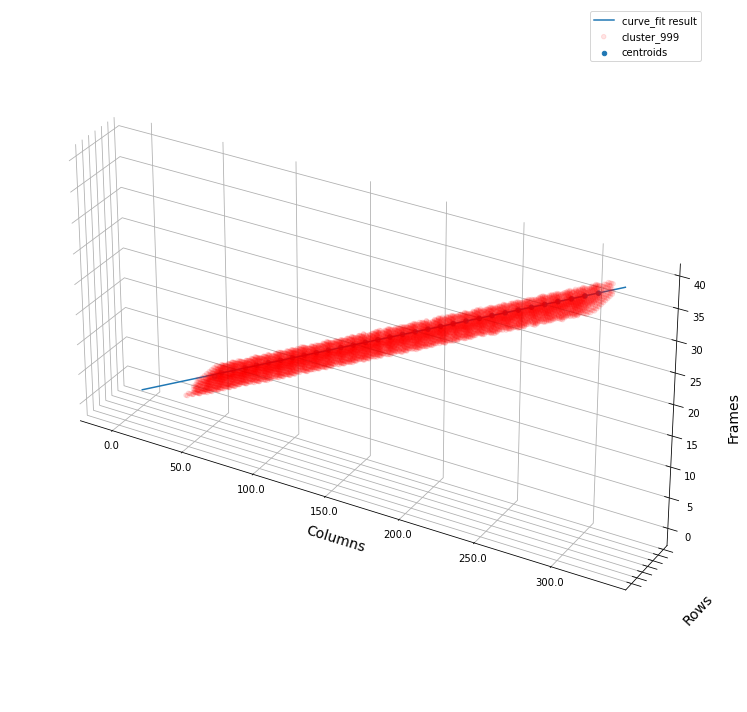

In [28]:
rampused = speedclustercombo(vel = 30, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscanf1v30cent', az = -60, el = 30,
                  flux = 1, colim = 99, cent = 1, mean = 1, setat = 1)